In [240]:
import os
import time
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import sklearn
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, max_error, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error 

import xgboost as xgb
from lightgbm import LGBMRegressor

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 

from bayes_opt import BayesianOptimization

warnings.filterwarnings("ignore")

In [241]:
#!pip install bayesian-optimization

In [242]:
%matplotlib inline

# Data

## Read data

In [243]:
main_path = 'D:/Resumes and Internships/Tests/Decathlon'

In [244]:
def get_path(path, extension=None):
    """
    Get absolute or relative path for file
    """
    output_path = os.path.join(main_path, path)
    output_path = output_path + '.' + extension if not extension is None else output_path
    
    if not os.path.exists(output_path):
        output_path = os.path.join('.', path)
        output_path = output_path + '.' + extension if not extension is None else output_path
        
    return output_path

In [245]:
df_train = pd.read_csv(get_path('data/train', 'csv'))
df_test  = pd.read_csv(get_path('data/test', 'csv'))
df_feat  = pd.read_csv(get_path('data/bu_feat', 'csv'))

## Exploring data

In [246]:
df_train.head(10)

,day_id,but_num_business_unit,dpt_num_department,turnover
0,2017-09-30,64,127,580.308443
1,2017-09-30,119,127,1512.995918
2,2017-09-30,4,88,668.593556
3,2017-09-30,425,127,0.000000
4,2017-09-30,513,73,0.000000
5,2017-09-30,211,88,271.276864
6,2017-09-30,10,117,21.436326
7,2017-09-30,177,88,193.990051
8,2017-09-30,39,73,265.385406
9,2017-09-30,214,88,718.790912


In [247]:
df_test.head(10)

,day_id,but_num_business_unit,dpt_num_department
0,2017-11-25,95,73
1,2017-11-25,4,117
2,2017-11-25,113,127
3,2017-11-25,93,117
4,2017-11-25,66,127
5,2017-11-25,225,88
6,2017-11-25,37,117
7,2017-11-25,720,73
8,2017-11-25,1015,127
9,2017-11-25,505,88


In [248]:
df_feat.head(10)

,but_num_business_unit,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr
0,1609,80100,50.096306,1.867220,69,4
1,1995,95700,48.991087,2.520903,3,6
2,1800,73210,45.552933,6.644736,51,4
3,238,47550,44.175370,0.638869,134,10
4,201,13546,43.508418,5.406423,71,10
5,242,72610,48.404324,0.087680,72,6
6,541,73100,45.718899,5.923290,51,4
7,95,80000,49.869382,2.280452,69,4
8,74,49071,47.467695,-0.619092,72,6
9,119,74100,46.195037,6.254448,51,4


In [249]:
df_train.describe()

,but_num_business_unit,dpt_num_department,turnover
count,277719.000000,277719.000000,277719.000000
mean,294.199464,101.288832,561.818472
std,291.664511,21.667318,2113.229765
min,1.000000,73.000000,-69.791165
25%,81.000000,88.000000,11.785140
50%,204.000000,88.000000,232.724186
75%,427.000000,127.000000,676.655825
max,1887.000000,127.000000,1000000.000000


In [250]:
df_test.describe()

,but_num_business_unit,dpt_num_department
count,10136.000000,10136.000000
mean,414.886346,101.207577
std,445.932616,21.679104
min,1.000000,73.000000
25%,95.000000,88.000000
50%,237.000000,88.000000
75%,549.000000,117.000000
max,1887.000000,127.000000


In [251]:
df_feat.describe()

,but_num_business_unit,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr
count,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000
mean,435.162577,51203.460123,47.002270,2.637551,63.199387,12.202454
std,474.138722,26716.870578,2.333283,2.786303,47.901374,18.605263
min,1.000000,1100.000000,41.954300,-4.436446,2.000000,1.000000
25%,97.250000,31000.000000,44.959619,0.707571,31.000000,4.000000
50%,242.500000,56050.000000,47.373887,2.598707,64.000000,6.000000
75%,553.750000,74575.000000,48.885216,4.904543,74.000000,10.000000
max,1995.000000,98000.000000,51.050275,8.796100,178.000000,72.000000


In [252]:
print("Number of rows with NaN values in train table   : ", len(df_train[df_train.isnull().any(axis=1)]))
print("Number of rows with NaN values in test table    : ", len(df_test[df_test.isnull().any(axis=1)]))
print("Number of rows with NaN values in features table: ", len(df_feat[df_feat.isnull().any(axis=1)]))

Number of rows with NaN values in train table   :  0
Number of rows with NaN values in test table    :  0
Number of rows with NaN values in features table:  0


The definition of outliers is tricky here as the stores and deps have different scales of sales, However, the aim here is to resolve extreme values so rather than picking **3**, i.e. the datapoints that sit between -3 and 3 times the std over the mean, I'll take **7**.

In [253]:
mean = df_train['turnover'].mean()
std = df_train['turnover'].std()

print("The number of extreme outliers in the data is :", len(df_train.loc[np.abs(df_train['turnover'] - mean >= (7 * std)), :]))
df_train = df_train.loc[np.abs(df_train['turnover'] - mean < (7 * std)), :]

The number of extreme outliers in the data is : 14


In [254]:
dep_buns_train = (df_train['dpt_num_department']*1000 + df_train['but_num_business_unit']).unique()
dep_buns_test  = (df_test['dpt_num_department']*1000 + df_test['but_num_business_unit']).unique()
outcasts = [_ for _ in dep_buns_test if not _  in dep_buns_train]

print("The number of department-businessunit combinations for which we don't have historical data is : ",  len(outcasts))

The number of department-businessunit combinations for which we don't have historical data is :  0


Since we lack the data for a non-null number of combinations, it would be difficult to use a time series analysis to predict turnover for all combinations accross the board given that we won't take into account the features for such method. 

A possible solution would be to predict the aggregated turnover and then break it up by department and business unit but this requires a forecast of their shares which then again need historical data.

While a model that uses the numerical features of the training data is logically gonna perform better than 

### Limit data for training

In [255]:
limit_row = int(322*4*52)
df_train.loc[:, 'day_id'] = pd.to_datetime(df_train['day_id'])
df_train = df_train.sort_values(by='day_id').iloc[:limit_row,:]

## Preprocess data

In [256]:
def process_date_col(df):
    """
    Create date related columns from the date
    """
    df = df.copy()
    df.loc[:, "date"] = pd.to_datetime(df["day_id"])
    df.loc[:, "year"] = df["date"].dt.year
    df.loc[:, "month"] = df["date"].dt.month
    df.loc[:, 'woy'] = df["date"].dt.week
    return df

In [257]:
columns_mapping = {
                  "but_num_business_unit" : "bun",
                  "dpt_num_department"    : "dep",
                  "but_postcode"          : "zip",
                  "but_latitude"          : "lat",
                  "but_longitude"         : "lon",
                  "but_region_idr_region" : "reg",
                  "zod_idr_zone_dgr"      : "zod"
                 }

In [258]:
def season_col(df, woy):
    """
    Adds 4 columns corresponding to the season
    """
    # Roughly
    mapping = {'win': [49,50,51,52] + list(range(0,9)),
              'spr': list(range(9,22)),
              'smm': list(range(22,35)),
              'aut': list(range(35,49))}
    
    for key, value in mapping.items():
       df.loc[:, key] = (df[woy].isin(value)).astype(int)

    return df

In [259]:
df_train = process_date_col(df_train).rename(columns = columns_mapping, inplace = False)
df_feat = df_feat.rename(columns = columns_mapping, inplace = False)

In [260]:
df_train = df_train.merge(df_feat, on='bun', how='left').sort_values(by=['year', 'month', 'bun', 'dep']).reset_index()

In [261]:
df_train = season_col(df_train, 'woy')

In [262]:
features = ['year', 'month', 'woy', 'bun', 'dep', 'win', 'spr', 'smm', 'aut', 'lat', 'lon', 'reg', 'zod']
target = ['turnover']

df_train = df_train[features + target]

## Prep questions 1 - 2  - 3 

In [263]:
result = df_train.loc[df_train['year']==2016, ['dep', 'turnover']].groupby(['dep']).sum().sort_values(by='turnover', ascending=False)

In [264]:
index = list(result.index)
print("The department that had the highest turnover during 2016 is : ",  index[0] if index else 'NA')

The department that had the highest turnover during 2016 is :  NA


In [265]:
result = df_train.loc[df_train['dep']==88, ['woy', 'turnover']].groupby(['woy']).sum().sort_values(by='turnover', ascending=False).head(5)

In [266]:
print("The top 5 week numbers for department 88 in 2015 in terms of turnover over all stores are : ", list(result.index))

The top 5 week numbers for department 88 in 2015 in terms of turnover over all stores are :  [2, 10, 3, 11, 9]


In [267]:
result = df_train.loc[df_train['year']==2014, ['bun', 'turnover']].groupby(['bun']).sum().sort_values(by='turnover', ascending=False)

In [268]:
index = list(result.index)
print("The top performer store in 2014 is : ", index[0] if index else 'NA')

The top performer store in 2014 is :  189


## Plots

### Correlation

In [269]:
plot_cor = False # Requires a lot of compute

if plot_cor:
    _ = pd.plotting.scatter_matrix(df_train, figsize=(15,15), diagonal='kde')

### Total turnover per different levels

#### Per year and week

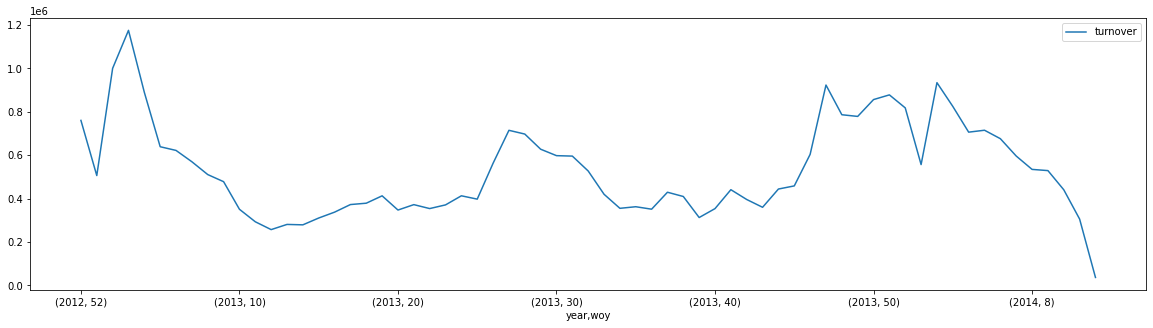

In [270]:
df_train[['year', 'woy', 'turnover']].groupby(['year', 'woy']).sum().plot(y='turnover', figsize=(20,5))

#### Per department

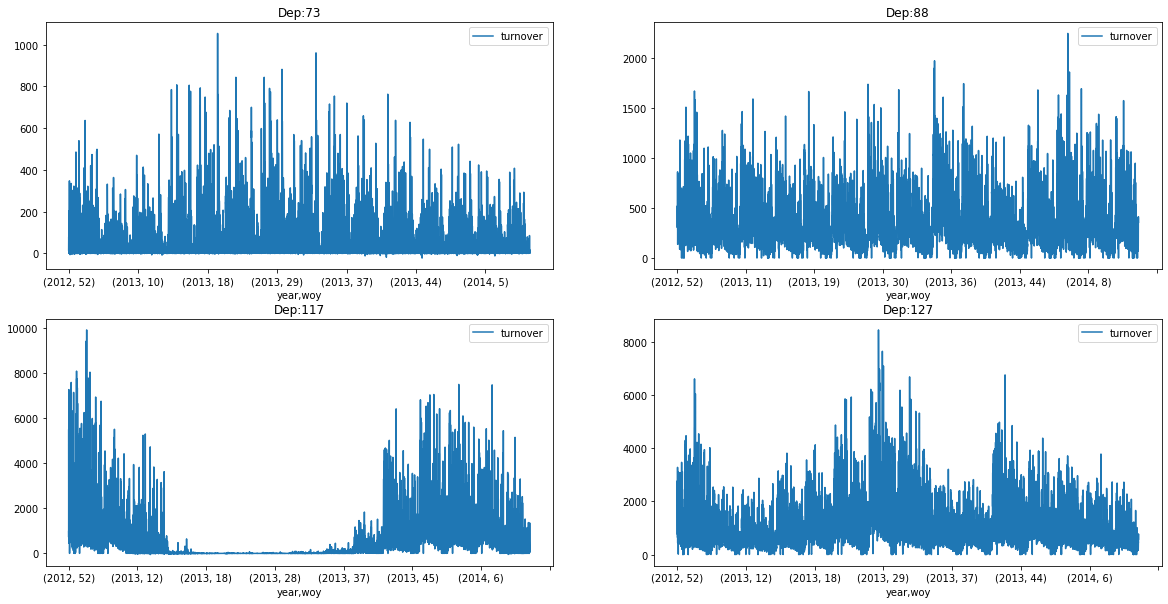

In [271]:
counter = 0
n_rows, n_cols = 2, 2
deps = df_train['dep'].unique()
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20,10))

for row in range(n_rows):
    for col in range(n_cols):
        ax = axes[row,col]
        sample = df_train.loc[df_train['dep']==deps[counter],:].copy().set_index(['year', 'woy'])
        sample.plot(y='turnover', ax=ax)
        ax.set_title(f'Dep:{deps[counter]}')
        counter += 1

## Prep questions: 4 - 5

In [272]:
years = list(df_train['year'].unique())

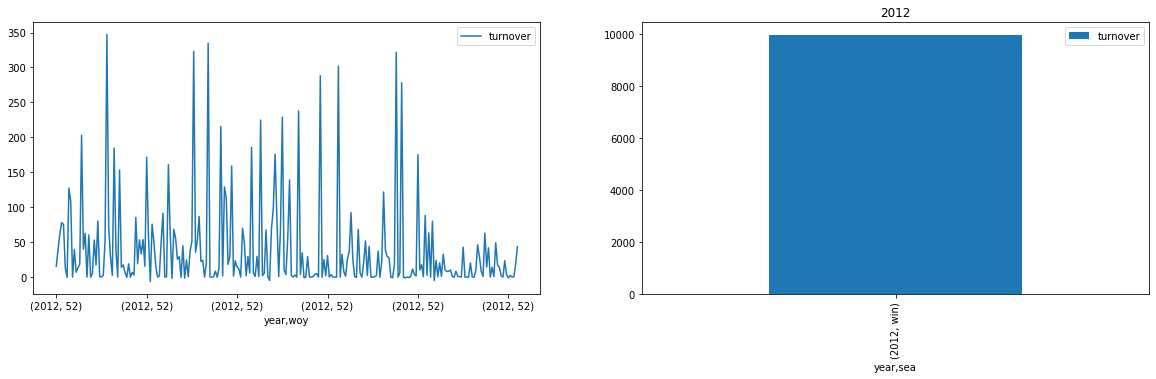

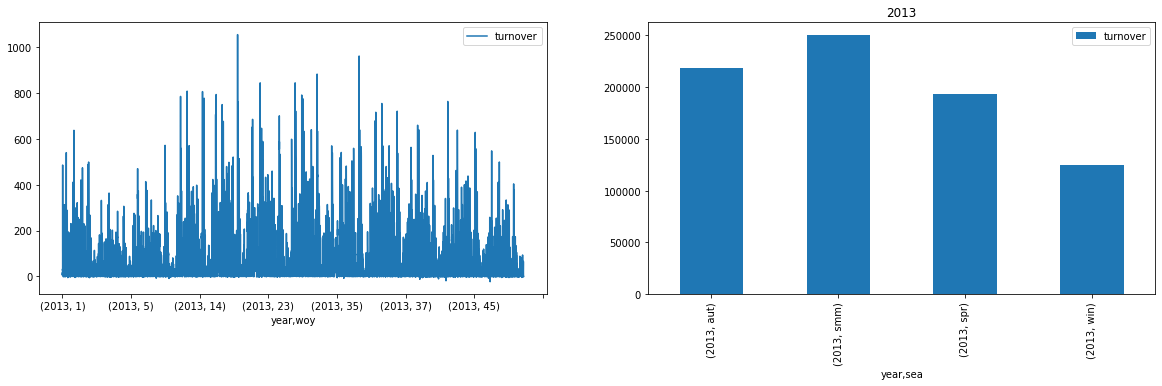

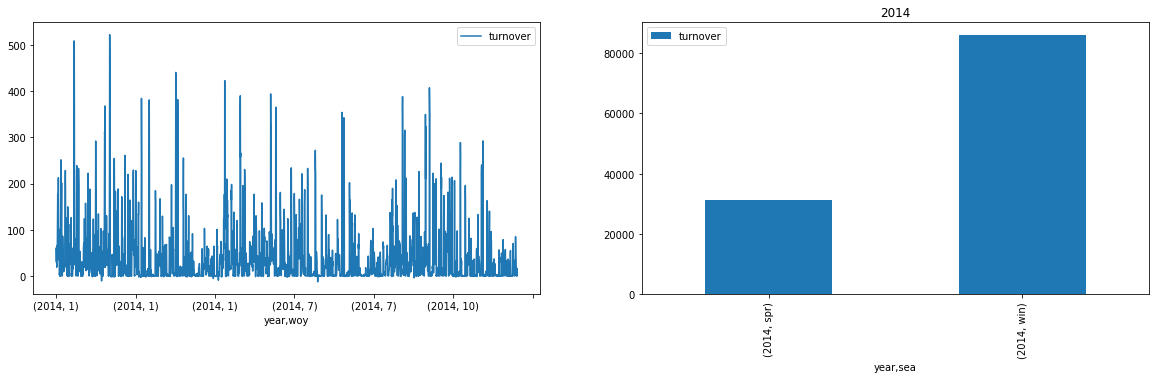

In [273]:
for year in years:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    sample =  df_train.loc[(df_train['dep']==73)&(df_train['year']==year), :].copy()
    sample.loc[:, 'sea'] = sample[['win', 'spr', 'smm', 'aut']].fillna(0).idxmax(1)
    sample_1 = sample.set_index(['year', 'woy'])
    sample_2 = sample.groupby(['year', 'sea']).sum()
    sample_1.plot(ax=axes[0], y='turnover')
    sample_2.plot(ax=axes[1], y='turnover', kind='bar')
    plt.title(f'{year}')

From the plots above, it seems that the department 73 has a slightly higher values during spring and summer (full-data years), however, isn't enough to conclude that the sport is a summer-only one. In order to ver

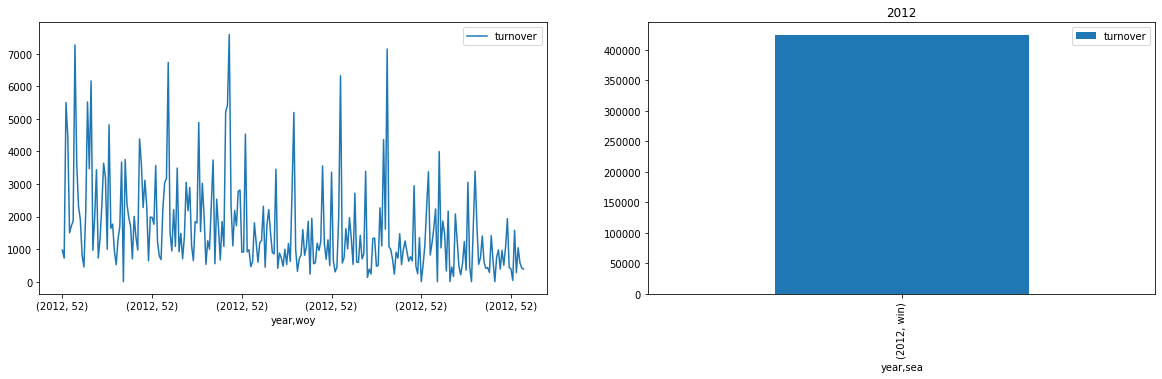

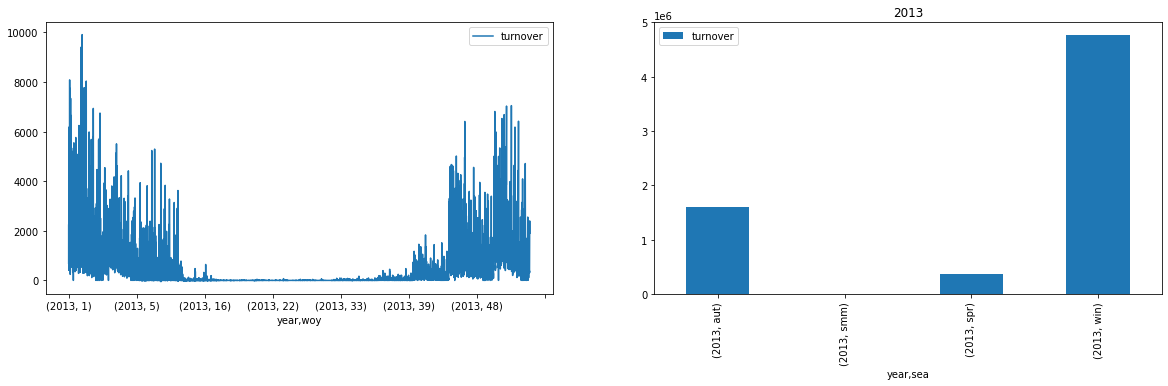

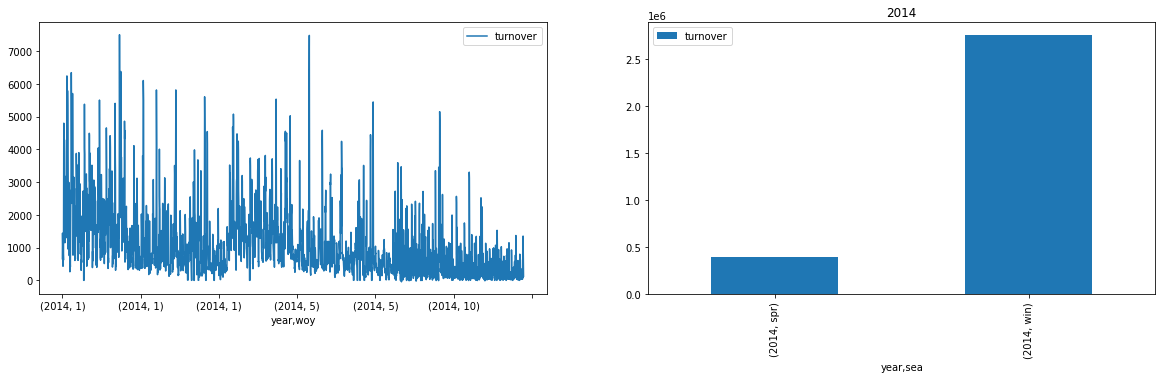

In [274]:
for year in years:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    sample =  df_train.loc[(df_train['dep']==117)&(df_train['year']==year), :].copy()
    sample.loc[:, 'sea'] = sample[['win', 'spr', 'smm', 'aut']].fillna(0).idxmax(1)
    sample_1 = sample.set_index(['year', 'woy'])
    sample_2 = sample.groupby(['year', 'sea']).sum()
    sample_1.plot(ax=axes[0], y='turnover')
    sample_2.plot(ax=axes[1], y='turnover', kind='bar')
    plt.title(f'{year}')

Unlike the department 73, the data for departement 117 is almost uni-model around December and January, indicating that this department specializes in winter sports (Although the rising amount of sales does not necessarly reflect an interest in the sport rather most likely the growth of the client, it may be that the sport is Ski). 

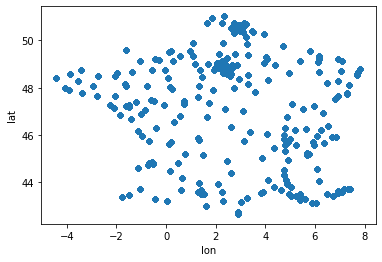

In [275]:
df_train.loc[df_train['dep']==117, ['lon', 'lat']].plot(y='lat', x='lon', kind='scatter')

With no special geographic distribution of the business units in France, we can't go further in the analysis. The higher density of stores in Paris, Lille, Lyon, Marseille could be due to the fact that these cities are finally amongst the high-population locations in France.

#### **Insights**

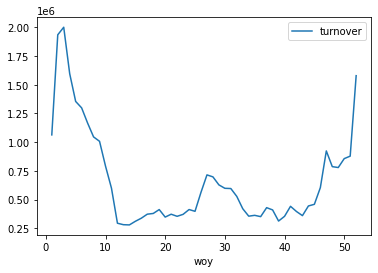

In [276]:
df_train.loc[:, ['woy', 'turnover']].groupby('woy').sum().plot(y='turnover')

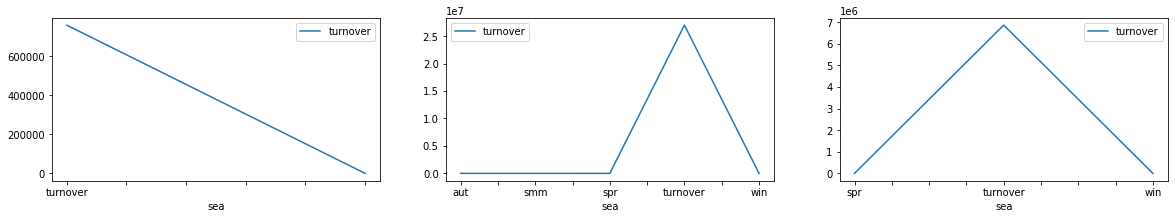

In [277]:
fig, axes = plt.subplots(nrows=1, ncols=len(years), figsize=(20,3))
sample_test = df_train.copy()
sample_test.loc[:, 'sea'] = sample_test[['win', 'spr', 'smm', 'aut', 'turnover']].fillna(0).idxmax(1)

for i, year in enumerate(years):
    sample_test.loc[sample_test['year']==year, ['sea', 'turnover']].groupby('sea').sum().plot(ax=axes[i], y='turnover')

The plots hereabove show that the highest amount of sales is due during winter (in average).

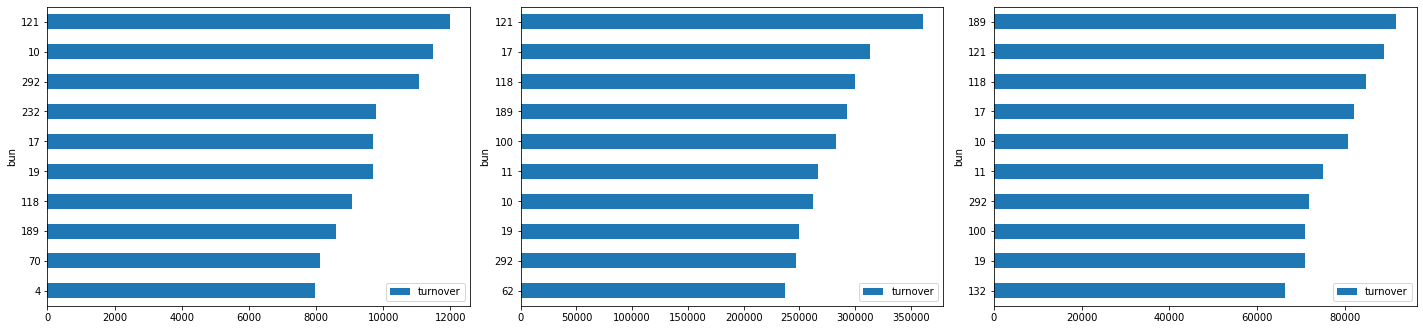

In [278]:
fig, axes = plt.subplots(1, len(years), figsize=(20,5))
plt.tight_layout(pad=2)

for i, year in enumerate(years):
    sample = df_train.loc[df_train['year']==year, ['bun', 'turnover']].groupby('bun').sum().reset_index()
    sample.sort_values(by='turnover').tail(10).plot.barh(x='bun', y='turnover', ax=axes[i])

Since there aren't external sources that will allow us to predict the share of the sales per store, we can't conceive a model that predicts the overall sales per department (which seems to be easier since the curves show a clear seasonality in the data) that we can then partition over the stores

Text(0.5, 1.0, 'Datapoints by dep and bun')

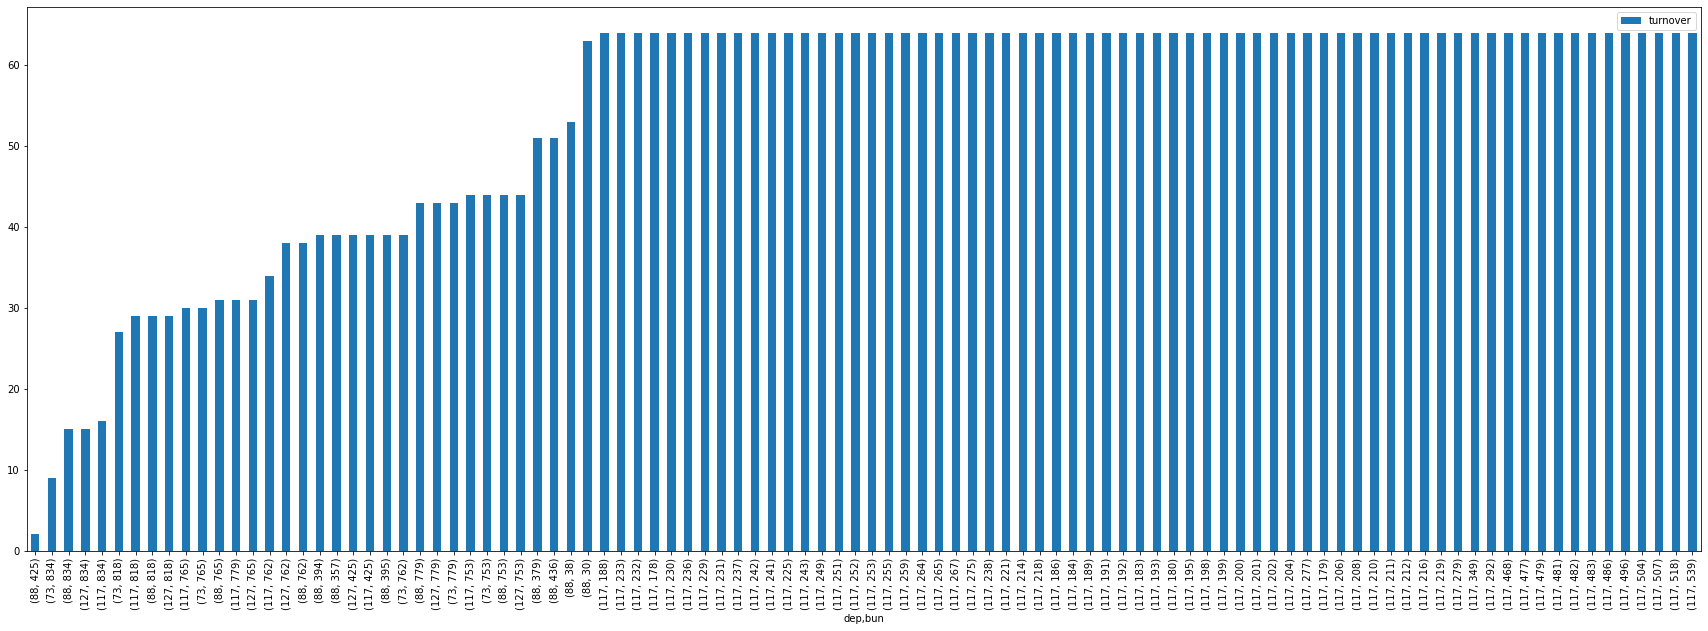

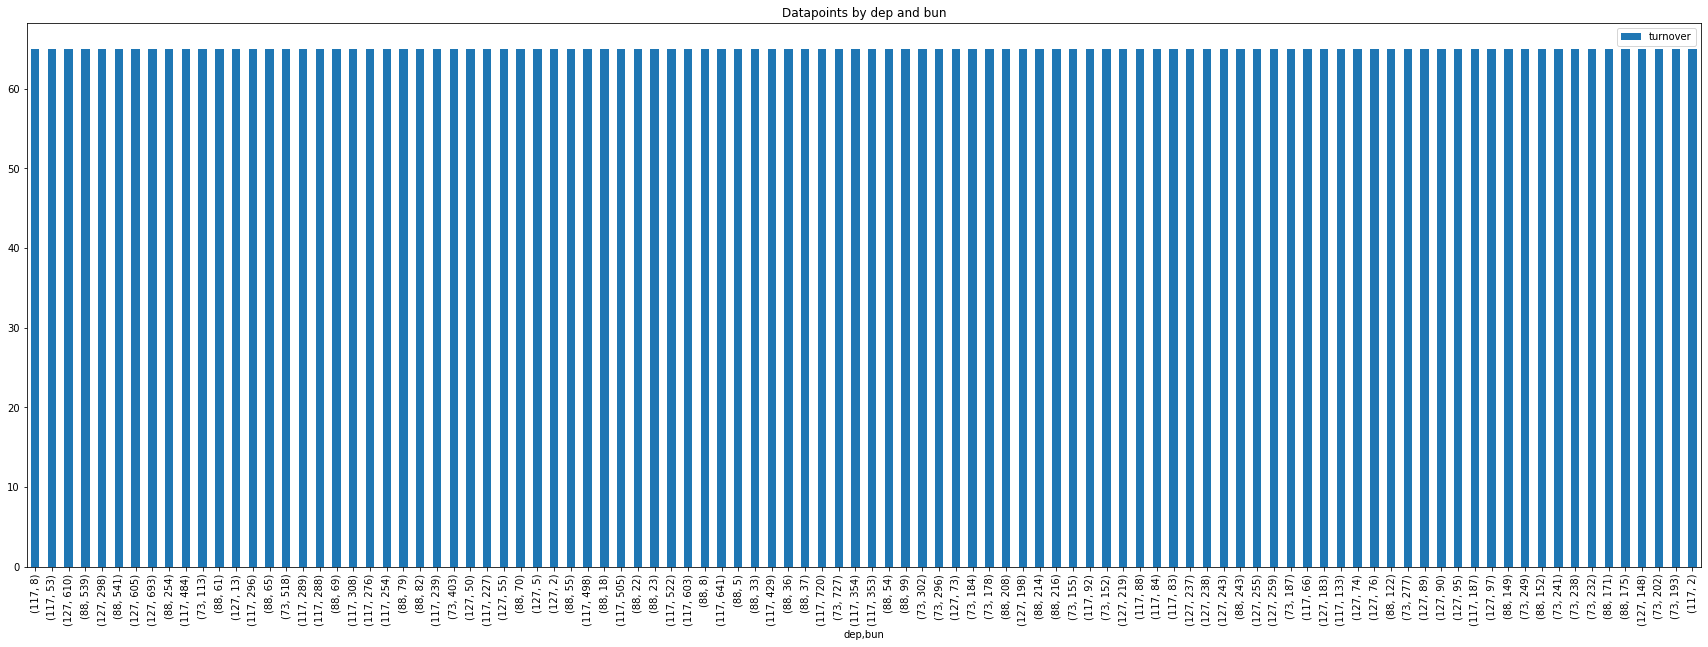

In [279]:
sample_1 = df_train.groupby(['dep', 'bun']).count().sort_values('turnover')
sample_2 = df_train.groupby(['bun']).count().sort_values('turnover')
sample_3 = df_train.groupby(['dep']).count().sort_values('turnover')

_ = sample_1.iloc[:100,:].plot(y='turnover', kind='bar', figsize=(30,10))
_ = sample_1.iloc[-100:,:].plot(y='turnover', kind='bar', figsize=(30,10))
plt.title('Datapoints by dep and bun')

Text(0.5, 1.0, 'Datapoints by bun')

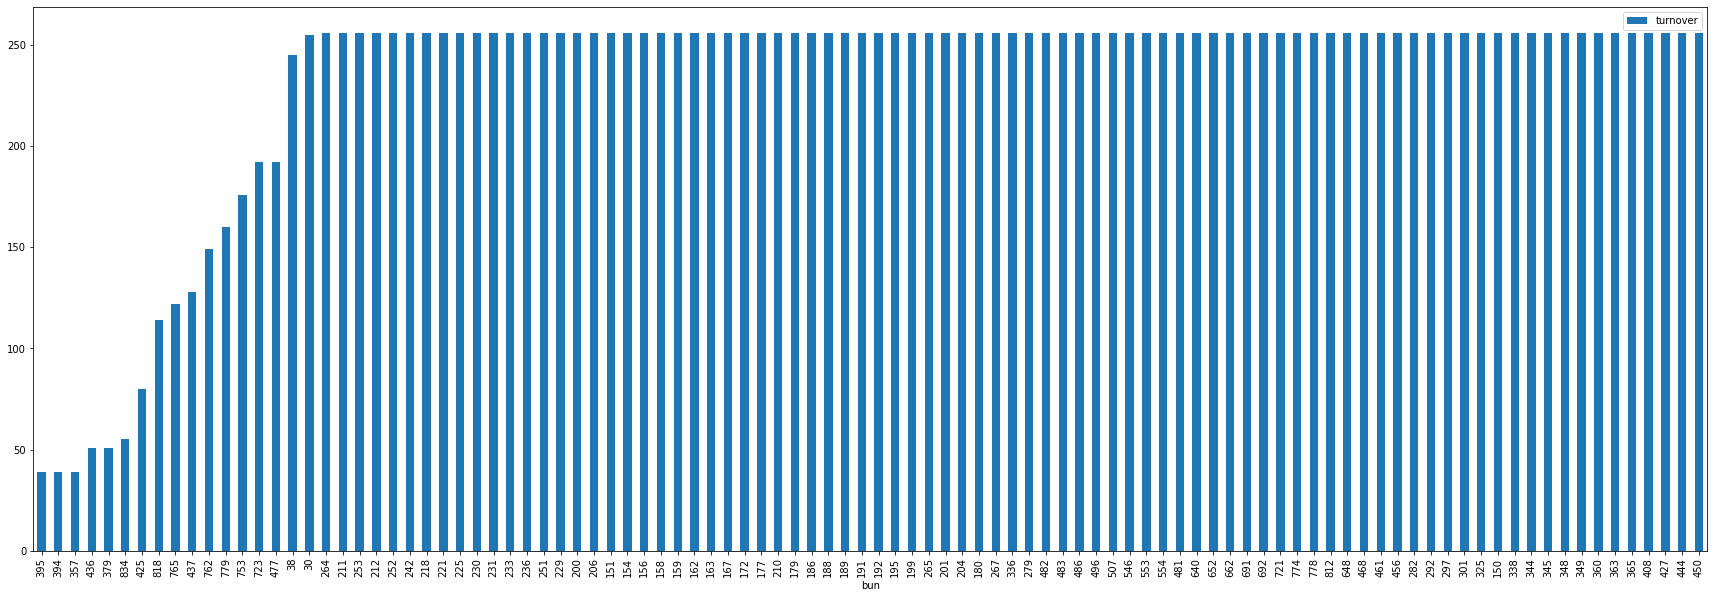

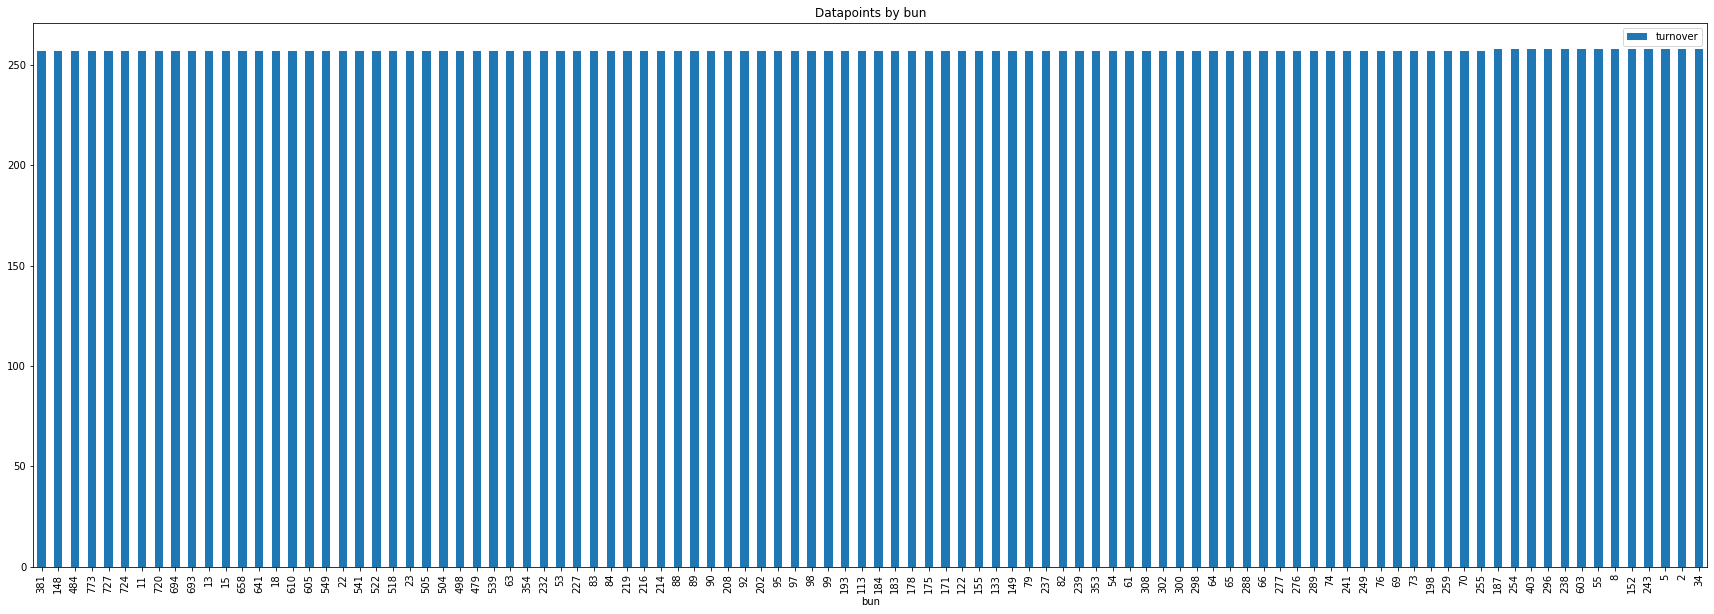

In [280]:
_ = sample_2.iloc[:100,:].plot(y='turnover', kind='bar', figsize=(30,10))
_ = sample_2.iloc[-100:,:].plot(y='turnover', kind='bar', figsize=(30,10))
plt.title('Datapoints by bun')

Text(0.5, 1.0, 'Datapoints by dep')

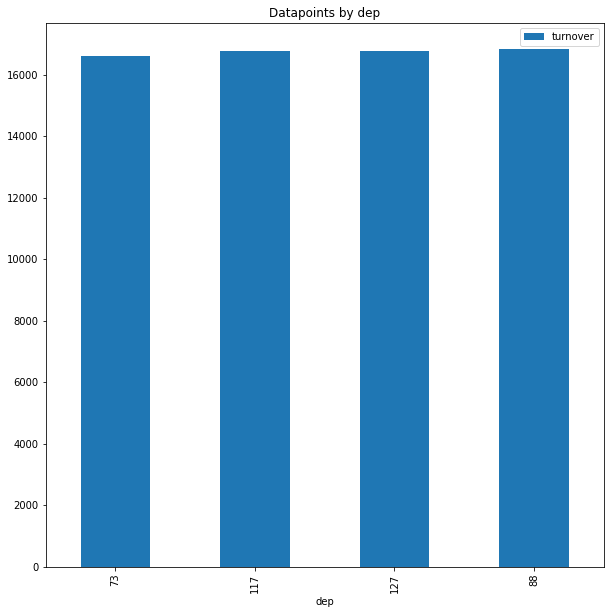

In [281]:
_ = sample_3.plot(y='turnover', kind='bar', figsize=(10,10))
plt.title('Datapoints by dep')

We can conclude that there shoudn't be any bias induced by the share of datapoints

# Models

### Helper functions

In [282]:
def save_model(model, name):
    """
    Save the model to models dir
    """
    path = os.path.join(get_path('models'), name + '.txt')
    with open(path, 'wb') as file:
        pickle.dump(model, file)

def load_model(name):
    """
    Load the model from models dir in pickle format
    """
    path = os.path.join(get_path('models'), name + '.txt')
    with open(path, 'rb') as file:
        model = pickle.load(file)
    
    return model

## Preprocessing

In [283]:
def onehot_cols(df, columns):
    """
    One hot encoding of dataframe's columns in provided list
    """
    df = df.copy()
    for col in columns:
        tmp_encoded_data = pd.get_dummies(df[col], prefix=col)
        df[tmp_encoded_data.columns] = tmp_encoded_data
        df = df.drop(columns=[col], inplace=False)
    
    return df

In [284]:
df_train_uni = onehot_cols(df_train, ['bun', 'dep', 'reg', 'zod'])
df_train_multi = onehot_cols(df_train, ['reg', 'zod'])

## Uni-model approach

### Data

In [285]:
df_train_uni.head(10)

,year,month,woy,win,spr,smm,aut,lat,lon,turnover,bun_1,bun_2,bun_4,bun_5,bun_6,bun_8,bun_9,bun_10,bun_11,bun_12,bun_13,bun_14,bun_15,bun_16,bun_17,bun_18,bun_19,bun_20,bun_22,bun_23,bun_24,bun_25,bun_26,bun_27,bun_28,bun_29,bun_30,bun_31,bun_32,bun_33,...,bun_812,bun_818,bun_834,dep_73,dep_88,dep_117,dep_127,reg_2,reg_3,reg_4,reg_6,reg_7,reg_8,reg_30,reg_31,reg_32,reg_33,reg_51,reg_52,reg_53,reg_55,reg_64,reg_65,reg_66,reg_69,reg_70,reg_71,reg_72,reg_74,reg_75,reg_107,reg_115,reg_121,reg_134,zod_1,zod_3,zod_4,zod_6,zod_10,zod_35
0,2012,12,52,1,0,0,0,50.628060,2.957377,15.552508,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2012,12,52,1,0,0,0,50.628060,2.957377,306.927510,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2012,12,52,1,0,0,0,50.628060,2.957377,972.944128,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2012,12,52,1,0,0,0,50.628060,2.957377,665.646079,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,2012,12,52,1,0,0,0,50.741153,3.134613,38.474503,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,2012,12,52,1,0,0,0,50.741153,3.134613,316.231685,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6,2012,12,52,1,0,0,0,50.741153,3.134613,723.618419,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,2012,12,52,1,0,0,0,50.741153,3.134613,707.547441,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8,2012,12,52,1,0,0,0,43.600994,7.078160,62.361617,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
9,2012,12,52,1,0,0,0,43.600994,7.078160,465.821136,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Preprocessing

In [286]:
features = list(df_train_uni.columns)
features.remove('turnover')

X, y = df_train_uni[features].to_numpy(), df_train_uni['turnover'].to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Model testing

Visualy, it seems that a time series analysis won't cut it for this approach as there is no seasonality nor is the serie stationary

##### Mean predictor

In [287]:
mpred = np.ones_like(y_val)*np.mean(y_train)

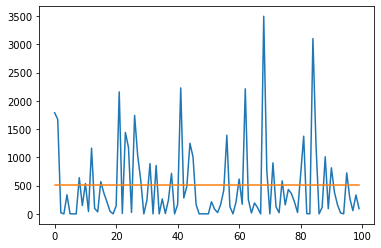

In [288]:
plt.plot(y_val[:100])
plt.plot(mpred[:100])

#### Decision Tree

In [289]:
# Arguments
criterion = 'mse' # ['mse', 'friedman_mse', 'mae']
splitter = 'best' # ['best', 'random']
max_depth = 7

# Model
dt_reg = DecisionTreeRegressor(criterion=criterion, splitter=splitter, max_depth=max_depth) 
dt_reg.fit(X_train, y_train)
print('Score is : ', dt_reg.score(X_val, y_val))

Score is :  0.5348456034056299


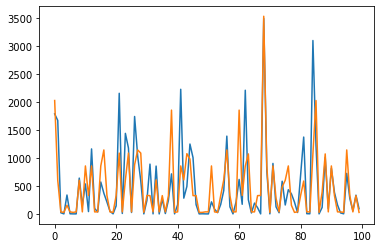

In [290]:
plt.plot(y_val[:100])
plt.plot(dt_reg.predict(X_val)[:100])

#### Random Forest

In [291]:
# Arguments
n_estimators = 20
criterion = 'mse' # ['mse', 'friedman_mse', 'mae']
max_depth = 4

# Model
rf_reg = RandomForestRegressor(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth) 
rf_reg.fit(X_train, y_train)
print('Score is : ', rf_reg.score(X_val, y_val))

Score is :  0.4556723555210893


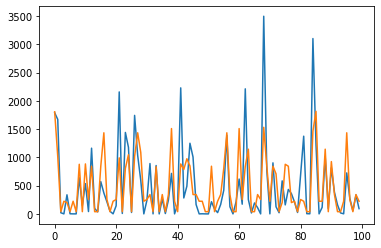

In [292]:
plt.plot(y_val[:100])
plt.plot(rf_reg.predict(X_val)[:100])

#### MLP 

In [293]:
# Params
n_hidden = 2
hidden_layer_sizes = tuple([50 for _ in range(n_hidden)])
solver = 'adam'             # ['sgd', 'adam']
activation = 'relu'         # ['relu', 'logistic', 'identity']
learning_rate = 'adaptive'  # ['constant', 'invscaling', 'adaptive']
learning_rate_init = 0.01   # [0.01, 0.05, 0.1]
max_iter = 400              
verbose = False

# Model
mlp_reg = MLPRegressor(
                       hidden_layer_sizes = hidden_layer_sizes,
                       solver = solver,
                       activation = activation,
                       learning_rate = learning_rate,
                       max_iter = max_iter,
                       verbose = verbose,
                       early_stopping = True
                      ) 

mlp_reg.fit(X_train, y_train)
print('Score is : ', mlp_reg.score(X_val, y_val))

Score is :  0.8325548300536258


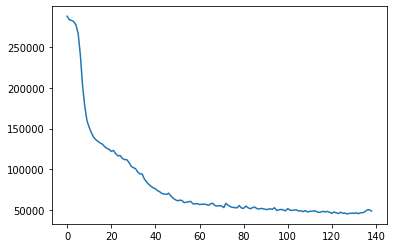

In [294]:
_ = plt.plot(mlp_reg.loss_curve_)

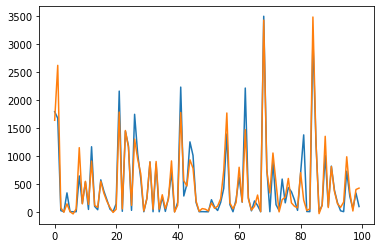

In [295]:
plt.plot(y_val[:100])
plt.plot(mlp_reg.predict(X_val)[:100])

#### Gradient Boosting

In [296]:
# Params
n_estimators = 20
loss = 'ls'   # ['ls', 'lad', 'huber', 'quantile']
learning_rate = 1.

gb_reg = GradientBoostingRegressor(
                                   n_estimators = n_estimators,
                                   loss = loss,
                                   learning_rate = learning_rate
                                  )

gb_reg.fit(X_train, y_train)
print('Score is : ', gb_reg.score(X_val, y_val))

Score is :  0.6464272461983045


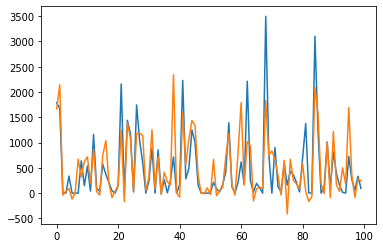

In [297]:
plt.plot(y_val[:100])
plt.plot(gb_reg.predict(X_val)[:100])

#### AdaBoost

In [298]:
# Params
n_estimators = 20
loss = 'linear'   #['linear', 'square', 'exponential'] 
learning_rate = 0.4

ada_reg = AdaBoostRegressor(
                            n_estimators = n_estimators,
                            loss = loss,
                            learning_rate = learning_rate
                            )

ada_reg.fit(X_train, y_train)
print('Score is : ', ada_reg.score(X_val, y_val))

Score is :  0.2505354020870203


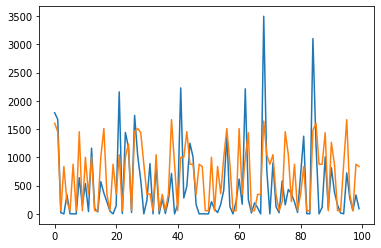

In [299]:
plt.plot(y_val[:100])
plt.plot(ada_reg.predict(X_val)[:100])

#### XGBoost

In [300]:
max_depth = 10

xgb_reg = xgb.XGBRegressor(max_depth=max_depth)
xgb_reg.fit(X_train, y_train)
print('Score is : ', xgb_reg.score(X_val, y_val))

[22:18:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Score is :  0.869697840132405


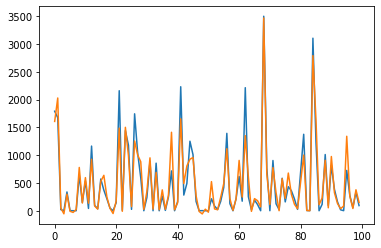

In [301]:
plt.plot(y_val[:100])
plt.plot(xgb_reg.predict(X_val)[:100])

### Model scoring

In [302]:
def get_scores(models, X, y, k=4):
    """
    Returns a DataFrame of two decimal numbers in binary digits.

    Parameters:
            models (dict): dictionary of scikit-Learn models
            k (int): folds for CV

    Returns:
            scores (pd.DataFrame): DataFrame detailing models
    """

    # kf = StratifiedShuffleSplit(n_splits=k, test_size=0.25, random_state=0)
    kf = KFold(n_splits=k)
    results = []

    for model in tqdm(models):
        
        # Init all scores
        scores = {
            'Name'     : model,
            'Max_error': 0,
            'Mae'      : 0,
            'Mse'      : 0,
            'MEae'     : 0, 
            'R2'       : 0,
            'Inference': 0
         }
        
        for train_index, val_index in kf.split(X):
            
            X_train_tmp = X[train_index]
            y_train_tmp = y[train_index]
            X_val_tmp = X[val_index]
            y_val_tmp = y[val_index]
            
            # Fitting the model
            models[model].fit(X_train_tmp, y_train_tmp)
            
            # Inference time
            a = time.time()
            y_val_hat = models[model].predict(X_val_tmp)
            b = time.time()

            # Cross validation
            scores['Max_error'] += max_error(y_val_hat, y_val_tmp)
            scores['Mae'      ] += mean_absolute_error(y_val_hat, y_val_tmp)
            scores['Mse'      ] += mean_squared_error(y_val_hat, y_val_tmp)
            scores['MEae'     ] += median_absolute_error(y_val_hat, y_val_tmp)
            scores['R2'       ] += r2_score(y_val_hat, y_val_tmp)
            scores['Inference'] += b-a
               
        mean_scores = {key: value/k if key!='Name' else value for (key,value) in scores.items()}
        results.append(mean_scores)

    return pd.DataFrame(results)    

In [303]:
models = {
          'Decision Tree'     : dt_reg,
          'Random Forest'     : rf_reg,
          'MLP regressor'     : mlp_reg,
          'Gradient Boosting' : gb_reg,
          'AdaBoost'          : ada_reg,
          'XGBoost'           : xgb_reg
         }

scores = get_scores(models, X, y, k=4)

 83%|████████▎ | 5/6 [05:30<01:09, 69.74s/it]

[22:25:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:29:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 6/6 [10:44<00:00, 107.43s/it]


In [304]:
scores

,Name,Max_error,Mae,Mse,MEae,R2,Inference
0,Decision Tree,6555.927230,286.396293,286346.886129,126.064751,0.046174,0.011834
1,Random Forest,7074.768810,329.493010,358102.354749,177.167978,-1.006813,0.021472
2,MLP regressor,6174.261819,247.163618,223638.207661,115.788092,0.199892,0.047335
3,Gradient Boosting,5872.600609,301.747684,260782.061750,166.812007,0.129968,0.021182
4,AdaBoost,6550.172861,488.185477,519255.491508,276.163724,-0.640004,0.207530
5,XGBoost,5117.573913,179.362234,125513.365256,76.335475,0.658973,0.140352


### Model tuning

In [305]:
def XGB_hyper_opt(learning_rate, n_estimators, max_depth):
    """
    Look for (sub-)optimal arg for the XGB regression model 
    """
    
    reg_model = xgb.XGBRegressor(learning_rate = learning_rate, 
                                 n_estimators  = int(n_estimators), 
                                 max_depth = int(max_depth)
                                 )
    
    score = get_scores({'Model': reg_model}, X, y, k=5)['Max_error'].to_numpy()[0]
    return np.nanmin([score, 0])

In [306]:
pbounds = {
    'learning_rate': (0.01, 0.5),
    'n_estimators': (5, 200),
    'max_depth': (3,10)
    }

optimizer = BayesianOptimization(f = XGB_hyper_opt,
                                 pbounds = pbounds,
                                 random_state = 1)

optimizer.maximize(init_points=5, n_iter=20)
best_candidate = optimizer.max['params']

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[22:30:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:31:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:32:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:32:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:33:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 1/1 [02:51<00:00, 171.96s/it]


|  1        |  0.0      |  0.2143   |  8.042    |  50.02    |


  0%|          | 0/1 [00:00<?, ?it/s]

[22:33:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:37:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:39:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:41:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 1/1 [09:17<00:00, 557.37s/it]


|  2        |  0.0      |  0.1942   |  8.529    |  166.2    |


  0%|          | 0/1 [00:00<?, ?it/s]

[22:43:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:45:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:46:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 1/1 [04:50<00:00, 290.15s/it]

|  3        |  0.0      |  0.2146   |  3.917    |  199.9    |


In [307]:
int_types = {'n_estimators': int,
             'max_depth': int}

best_candidate = {key: int_types[key](value) if key in int_types else value for key, value in best_candidate.items()}

In [350]:
xgb_reg_tuned = xgb.XGBRegressor(**best_candidate)
xgb_reg_tuned.fit(X_train, y_train)
print('Score is : ', xgb_reg_tuned.score(X_val, y_val))
save_model(xgb_reg_tuned, 'xgb_model')

[22:52:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Score is :  0.03520679132340221


### Prediction

For the moment, let's assume that we'll use the sklearn API so we can call on the prediction method from the model class

In [309]:
features = ['year', 'month', 'woy', 'bun', 'dep', 'win', 'spr', 'smm', 'aut', 'lat', 'lon', 'reg', 'zod']

df_test  = pd.read_csv(get_path('data/test', 'csv'))
df_test.loc[:, 'day_id'] = pd.to_datetime(df_test['day_id'])

Checking wether we need to add days to the test dataset to get to W+8

In [310]:
df_test.groupby(['dpt_num_department', 'but_num_business_unit']).count()

day_id
dpt_num_department but_num_business_unit        
73                 1                           8
                   2                           8
                   4                           8
                   5                           8
                   6                           8
...                                          ...
127                1876                        8
                   1881                        8
                   1882                        8
                   1883                        8
                   1887                        8

[1267 rows x 1 columns]

In [311]:
# Process test data set in the same fashion as the training one
df_test = process_date_col(df_test).rename(columns = columns_mapping, inplace = False)
df_test = df_test.merge(df_feat, on='bun', how='left').sort_values(by=['year', 'month', 'bun', 'dep']).reset_index()
df_test = season_col(df_test, 'woy')
df_test = df_test[features]

# Filter the testing department-businessunit combinations to the ones for which we have data
dep_buns = np.unique((df_train['bun']*1000).astype(str) + df_train['dep'].astype(str))
df_test_seen = df_test.loc[((df_test['bun']*1000).astype(str) + df_test['dep'].astype(str)).isin(dep_buns), :]
df_test_unseen = df_test.loc[~((df_test['bun']*1000).astype(str) + df_test['dep'].astype(str)).isin(dep_buns), :]

# Onehot encoding
df_test_seen = onehot_cols(df_test_seen, ['bun', 'dep', 'reg', 'zod'])

# Fill missing columns (assigning columns to dataframe that aren't in it has been deprecated)
cols = [_ for _ in df_train_uni.columns if not _ in  list(df_test_seen.columns) + ['turnover']]
for col in cols:
    df_test_seen.loc[:, col] = 0

In [312]:
# Cast dataframe to numpy array
X_test_seen = df_test_seen.to_numpy()

# Make prediction
y_pred_seen = xgb_reg_tuned.predict(X_test_seen)
y_pred_unseen = list(np.ones_like(df_test_unseen.index)*np.mean(y_train))

In [313]:
# Format prediction 
result_seen = pd.DataFrame(X_test_seen, columns=df_test_seen.columns)
result_unseen = df_test_unseen

result_seen.loc[:, 'turnover'] = y_pred_seen
result_unseen.loc[:, 'turnover'] = y_pred_unseen

# reverse onehot encoding
result_seen.loc[:, "bun"] = result_seen[[_ for _ in result_seen.columns if _[:3]=='bun']].idxmax(1).str[4:].astype(int)
result_seen.loc[:, "dep"] = result_seen[[_ for _ in result_seen.columns if _[:3]=='dep']].idxmax(1).str[4:].astype(int)

result = pd.concat([result_seen, result_unseen], ignore_index=True)

result.loc[:, 'date'] = (result['year']*100).astype(int) + result['woy'].astype(int)
result.loc[:, 'date'] = pd.to_datetime(result['date'].apply(lambda x: str(x)+'-0'), format="%Y%W-%w")

# Get final result
result = result[['date',	'bun',	'dep', 'turnover']]

In [314]:
result

,date,bun,dep,turnover
0,2017-10-29,1,73,19.980968
1,2017-10-22,1,73,19.980968
2,2017-10-15,1,73,19.980968
3,2017-10-08,1,73,19.980968
4,2017-10-29,1,88,296.955048
...,...,...,...,...
10131,2017-11-05,1887,88,517.029331
10132,2017-11-26,1887,127,517.029331
10133,2017-11-19,1887,127,517.029331
10134,2017-11-12,1887,127,517.029331


The high amount of preprocessing of the test data is due to my choice of considering that the business unit is a categorical value with no specific meaning to it. If it turns out that that's not the case, we can use it in the numerical format. 

## Multi-model approach

In [315]:
df_train_multi.head(10)

,year,month,woy,bun,dep,win,spr,smm,aut,lat,lon,turnover,reg_2,reg_3,reg_4,reg_6,reg_7,reg_8,reg_30,reg_31,reg_32,reg_33,reg_51,reg_52,reg_53,reg_55,reg_64,reg_65,reg_66,reg_69,reg_70,reg_71,reg_72,reg_74,reg_75,reg_107,reg_115,reg_121,reg_134,zod_1,zod_3,zod_4,zod_6,zod_10,zod_35
0,2012,12,52,1,73,1,0,0,0,50.628060,2.957377,15.552508,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2012,12,52,1,88,1,0,0,0,50.628060,2.957377,306.927510,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2012,12,52,1,117,1,0,0,0,50.628060,2.957377,972.944128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2012,12,52,1,127,1,0,0,0,50.628060,2.957377,665.646079,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,2012,12,52,2,73,1,0,0,0,50.741153,3.134613,38.474503,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,2012,12,52,2,88,1,0,0,0,50.741153,3.134613,316.231685,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6,2012,12,52,2,117,1,0,0,0,50.741153,3.134613,723.618419,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,2012,12,52,2,127,1,0,0,0,50.741153,3.134613,707.547441,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8,2012,12,52,4,73,1,0,0,0,43.600994,7.078160,62.361617,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
9,2012,12,52,4,88,1,0,0,0,43.600994,7.078160,465.821136,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [316]:
buns = sorted(list(df_train_multi['bun'].unique()))
deps = sorted(list(df_train_multi['dep'].unique()))

columns = df_train_multi.columns
columns = [_ for _ in columns if _ not in ['buns', 'dep']]

dfs = [[]]

for i, bun in enumerate(buns):
    for j, dep in enumerate(deps):
        sample = df_train_multi.loc[(df_train_multi['bun']==bun)&(df_train_multi['dep']==dep), columns].copy(True)
        sample = sample.sort_values(by=['year', 'month'])
        dfs[-1].append(sample)
        
    dfs.append([])

In [317]:
print("The departements for which we have data are : ", deps, '\n')
print("The business units for which we have data are : ", buns)

The departements for which we have data are :  [73, 88, 117, 127] 

The business units for which we have data are :  [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 87, 88, 89, 90, 92, 93, 95, 96, 97, 98, 99, 100, 109, 110, 113, 115, 116, 117, 118, 119, 121, 122, 125, 127, 129, 131, 132, 133, 134, 136, 139, 148, 149, 150, 151, 152, 154, 155, 156, 158, 159, 162, 163, 167, 171, 172, 175, 177, 178, 179, 180, 183, 184, 186, 187, 188, 189, 191, 192, 193, 195, 198, 199, 200, 201, 202, 204, 206, 208, 210, 211, 212, 214, 216, 218, 219, 221, 225, 227, 229, 230, 231, 232, 233, 236, 237, 238, 239, 241, 242, 243, 249, 251, 252, 253, 254, 255, 259, 264, 265, 267, 275, 276, 277, 279, 282, 288, 289, 292, 296, 297, 298, 300, 301, 302, 308, 325, 336, 338, 344, 345, 348

In [318]:
def plot_curves(bu=None, dep=None, n_rows=5, n_cols=3, figsize=(20,10)):
    """
    Plot curves of turnover for the parameters bun and dep in a n_rowsxn_cols grid
    """
    if not (bu is None or dep is None):
        i = buns.index(bu)
        j = deps.index(dep)
        dfs[i][j].set_index(['year', 'woy']).plot(y='turnover')
        plt.title(f'BU:{buns[i]} - Dep:{deps[j]} - {i}/{j}')
        return None
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    plt.tight_layout(pad=4)
    
    for row in range(n_rows):
        for col in range(n_cols):
            ax = axes[row,col]
            i = np.random.randint(len(buns)) if bu  is None else buns.index(bu)
            j = np.random.randint(len(deps)) if dep is None else deps.index(dep)
            sample = dfs[i][j].set_index(['year', 'woy'])
            sample.plot(y='turnover', ax=ax)
            ax.set_title(f'BU:{buns[i]} - Dep:{deps[j]} - {i}/{j}')

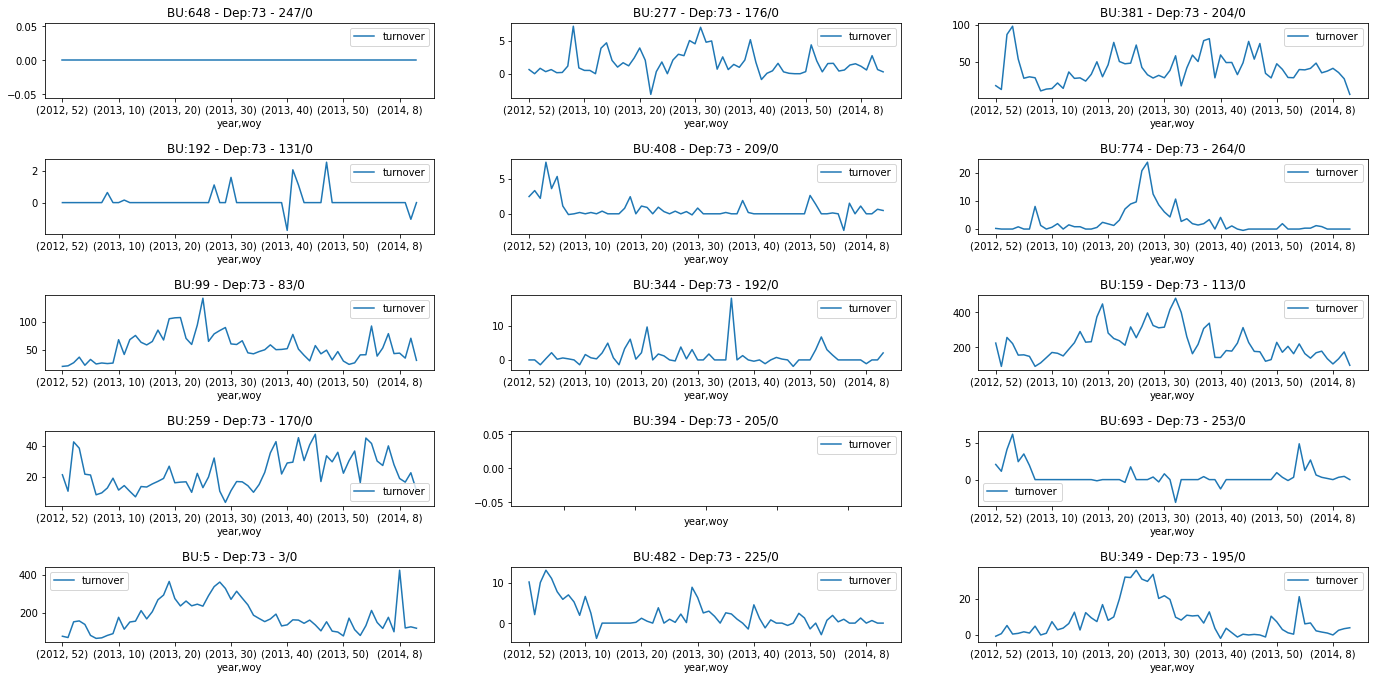

In [319]:
plot_curves(dep=73)

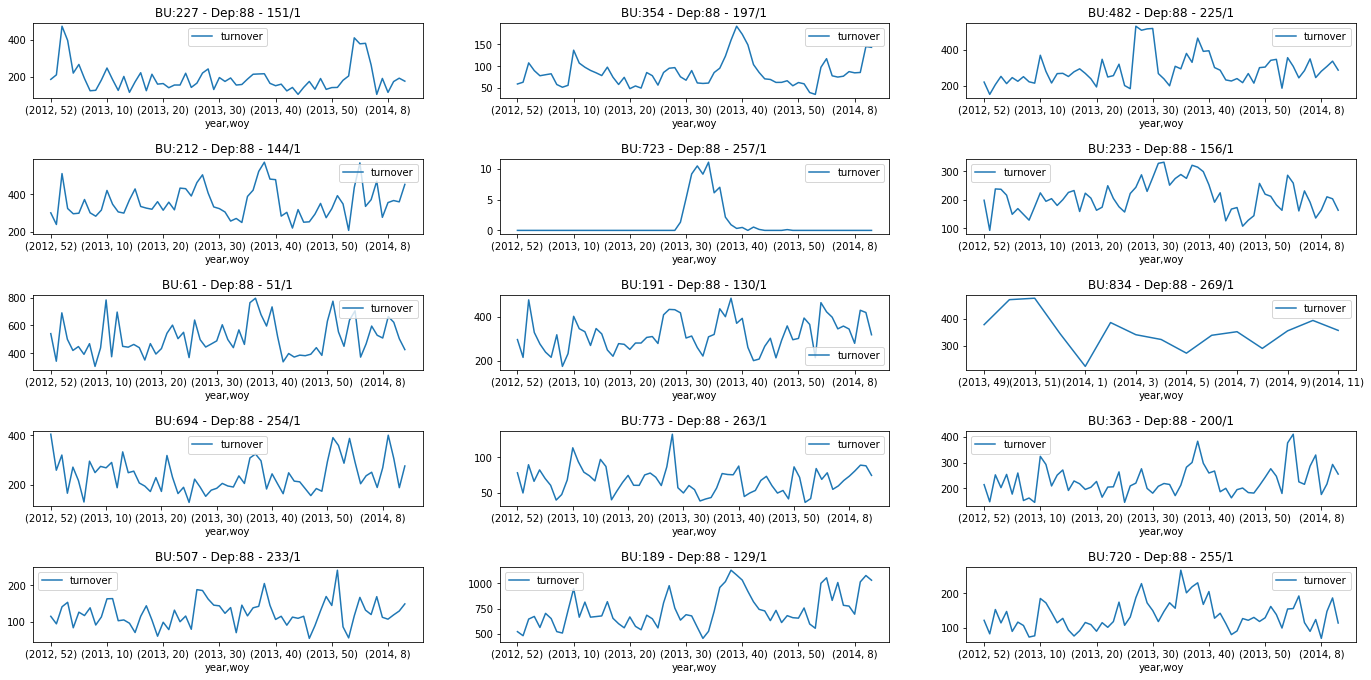

In [320]:
plot_curves(dep=88)

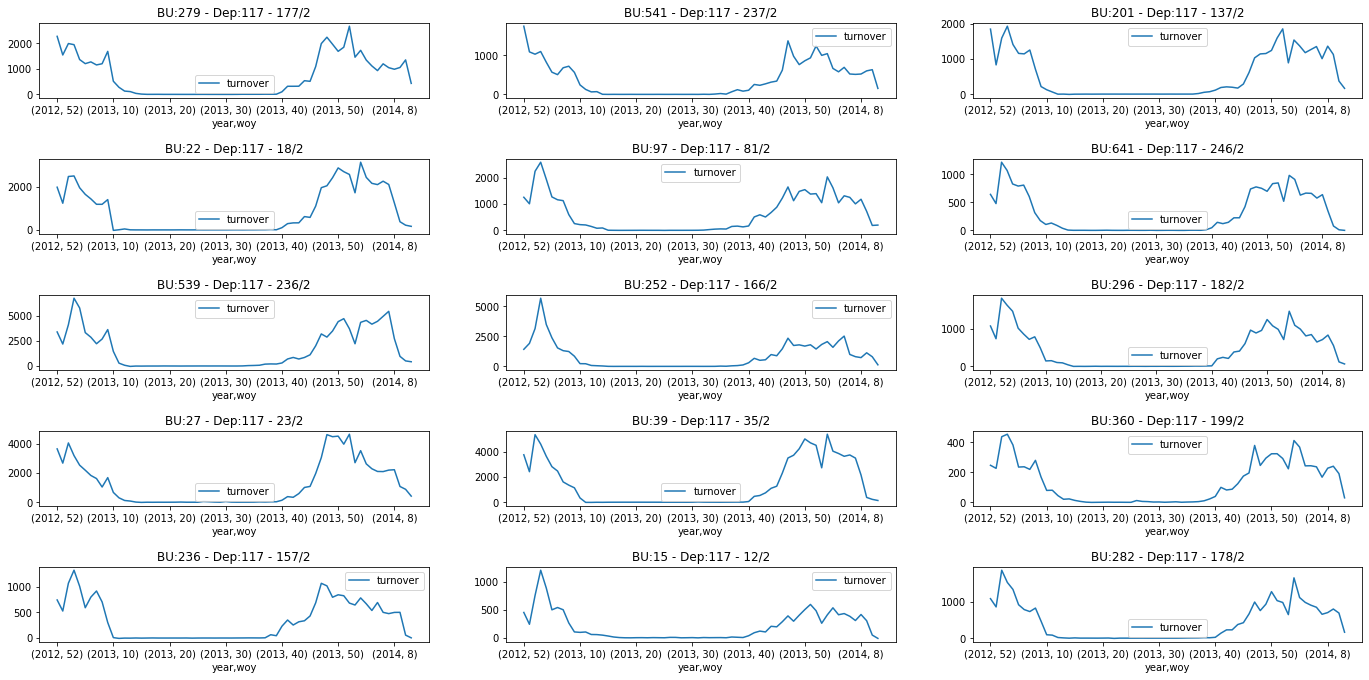

In [321]:
plot_curves(dep=117)

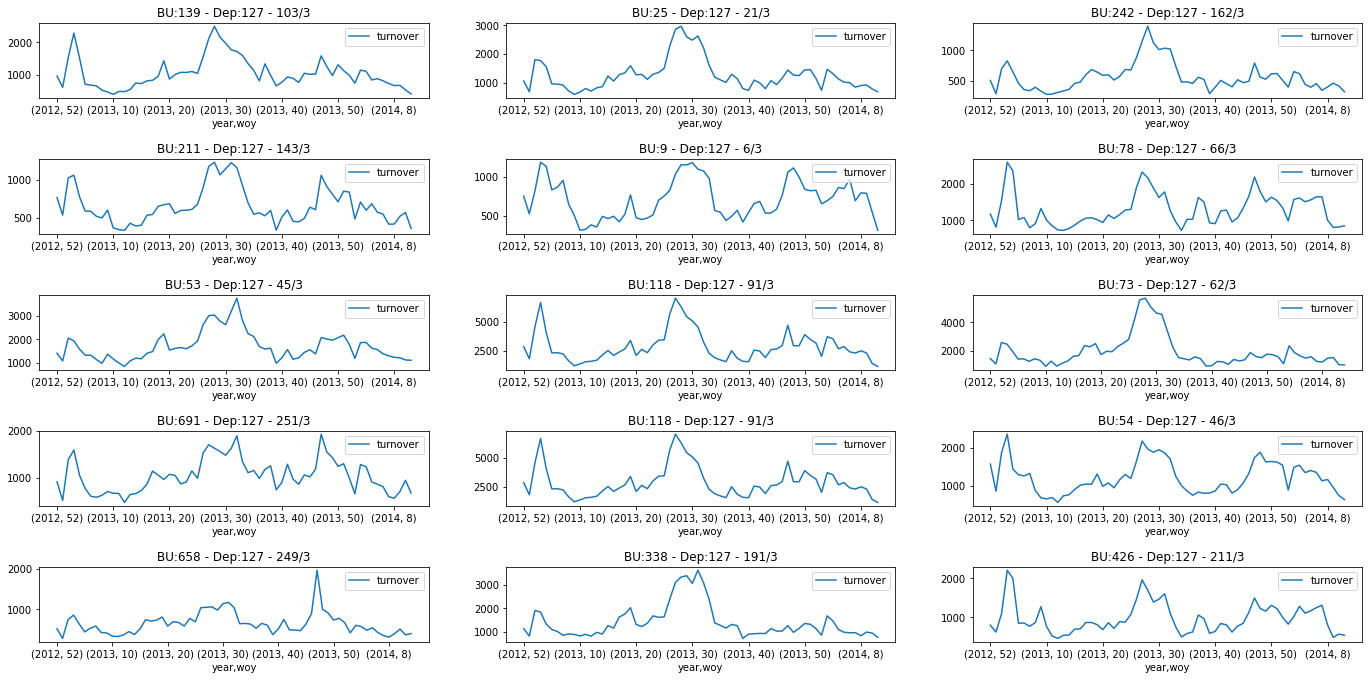

In [322]:
plot_curves(dep=127)

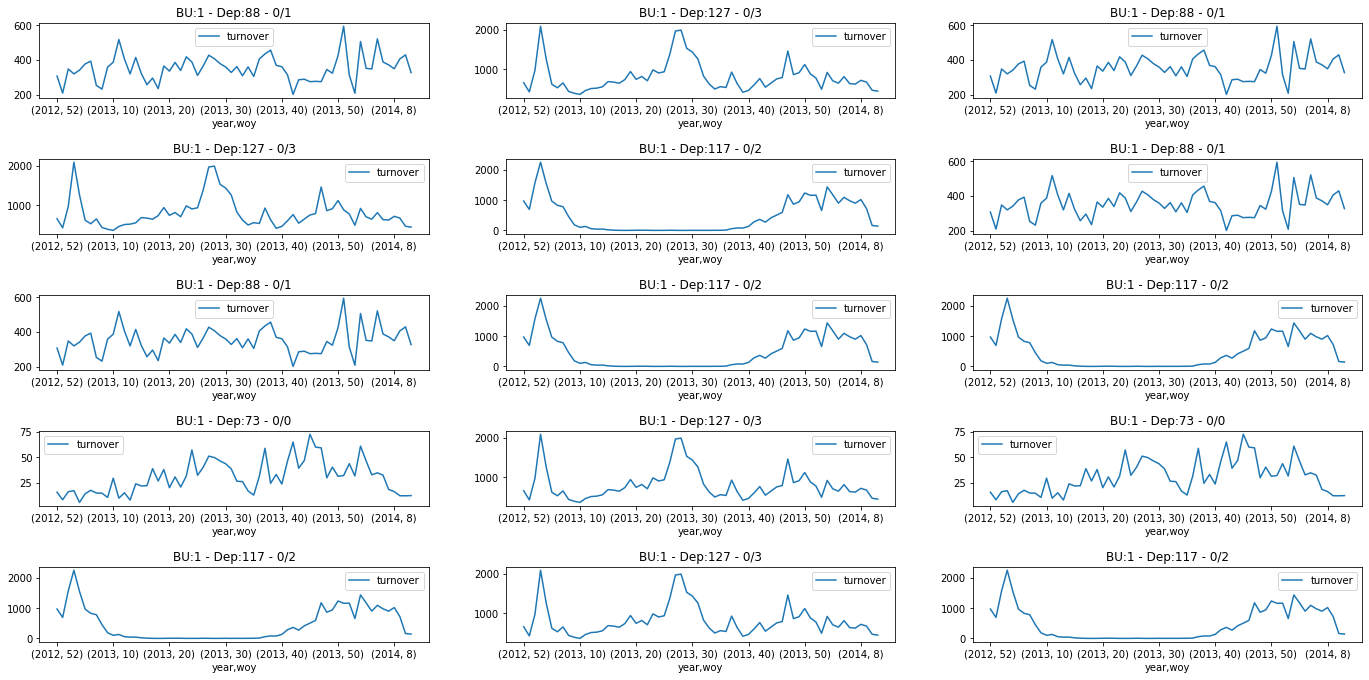

In [323]:
plot_curves(bu=1)

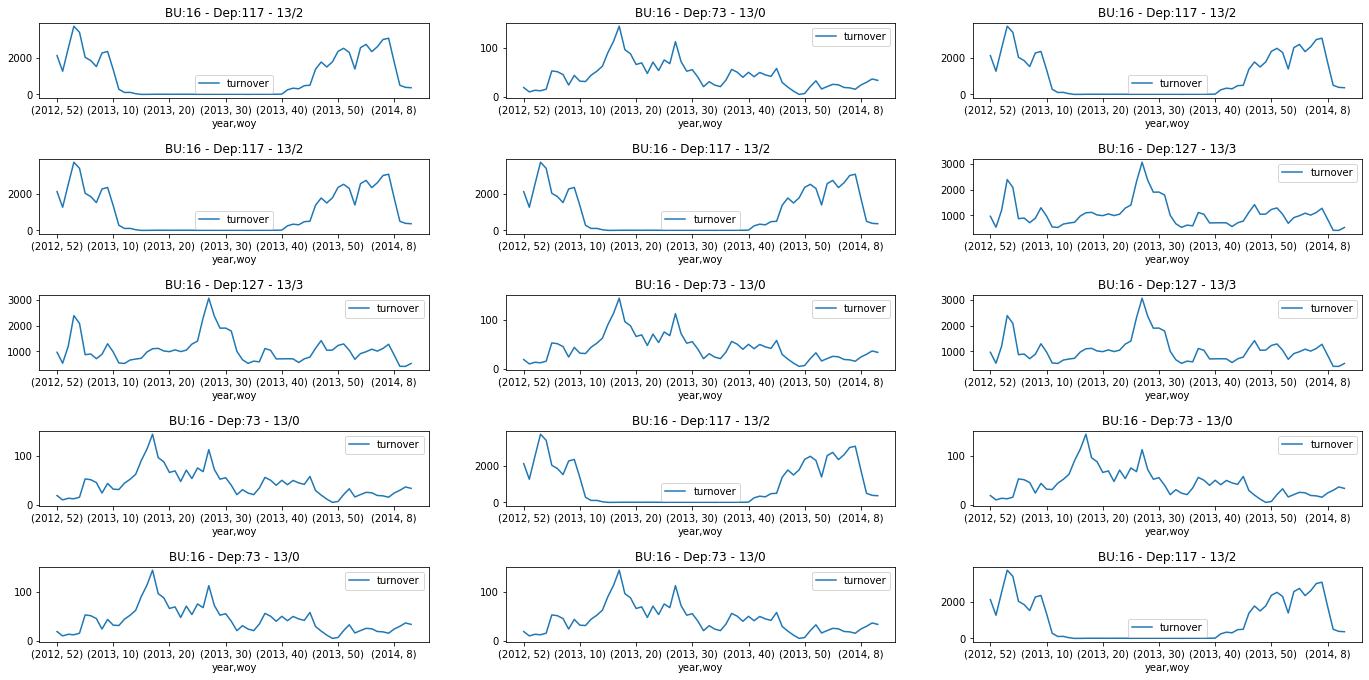

In [324]:
plot_curves(bu=16)

### Models

We will be looking for weak models in this approach given than we will have to maintain more than one model

In [325]:
def reccurent_dataset(X, n_features=1):
    """
    Transforms an array into a input series of features for (t-n_features), ..., (t-1)
    and a target corresponding to the next step (t)
    """
    features, target = [], []
    
    for i in range(len(X)-n_features-1):
        
        sample = X[i:(i + n_features)]
        features.append(sample)
        target.append(X[i + n_features])
    
    features, target = np.array(features), np.array(target)
    return features, target

In [326]:
dep = np.random.randint(len(deps))
bun = np.random.randint(len(buns))
features = list(dfs[0][0].columns)
features.remove('turnover')

# Test dataframe
df_multi_test = dfs[bun][dep]

# Data for feed forward models 
X, y = df_multi_test[features].to_numpy(), df_multi_test['turnover'].to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#### Dummy Regerssor

In [327]:
# Arguments
strategy = 'mean'# ['mean', 'median', 'quantile']

# Model
dm_reg = DummyRegressor(strategy=strategy)
dm_reg.fit(X_train, y_train)
print('Score is : ', dm_reg.score(X_val, y_val))

Score is :  -0.0021430093192897903


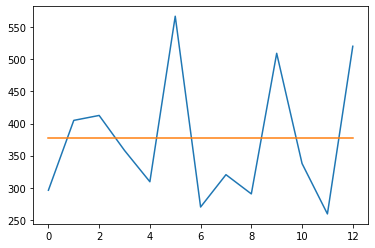

In [328]:
plt.plot(y_val)
plt.plot(dm_reg.predict(X_val))

#### Decision Tree

In [329]:
# Arguments
criterion = 'mse' # ['mse', 'friedman_mse', 'mae']
splitter = 'best' # ['best', 'random']
max_depth = 20

# Model
dt_reg = DecisionTreeRegressor(criterion=criterion, splitter=splitter, max_depth=max_depth) 
dt_reg.fit(X_train, y_train)
print('Score is : ', dt_reg.score(X_val, y_val))

Score is :  0.03780405806354992


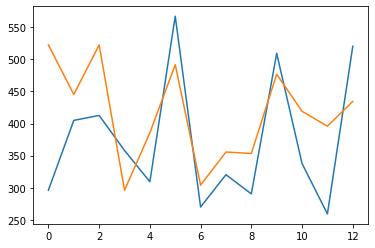

In [330]:
plt.plot(y_val)
plt.plot(dt_reg.predict(X_val))

#### LightGBM

In [331]:
# Arguments
n_estimators = 30
learning_rate  = 0.5
max_depth = 10

# Model
lgbm_reg = LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, min_data_in_leaf=0, min_sum_hessian_in_leaf=0) 
lgbm_reg.fit(X_train, y_train)
print('Score is : ', lgbm_reg.score(X_val, y_val))

Score is :  0.35347135861709444


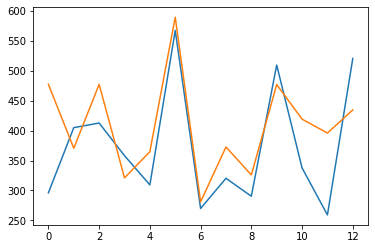

In [332]:
plt.plot(y_val)
plt.plot(lgbm_reg.predict(X_val))

In [333]:
# Data for recurrent models
n_features = 5
y = df_multi_test['turnover'].to_numpy()
X_rec, y_rec = reccurent_dataset(y, n_features=n_features)
X_rec_train, X_rec_val, y_rec_train, y_rec_val = train_test_split(X_rec, y_rec, test_size=0.2, random_state=42)

#### LSTM

In [334]:
lstm = Sequential()
lstm.add(LSTM(64, return_sequences=True, input_shape=(1, n_features)))
lstm.add(LSTM(128, return_sequences=True))
lstm.add(LSTM(128, return_sequences=True))
lstm.add(Dense(1))

lstm.compile(loss='mean_squared_error', optimizer='adagrad')
lstm.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 1, 64)             17920     
_________________________________________________________________
lstm_16 (LSTM)               (None, 1, 64)             33024     
_________________________________________________________________
dense_6 (Dense)              (None, 1, 1)              65        
Total params: 51,009
Trainable params: 51,009
Non-trainable params: 0
_________________________________________________________________


In [335]:
history = lstm.fit(np.expand_dims(X_rec_train, axis=1), y_rec_train, epochs = 2000) #3000

Epoch 1/2000
2/2 [==============================] - 3s 7ms/step - loss: 150108.8125
Epoch 2/2000
2/2 [==============================] - 0s 5ms/step - loss: 150058.3281
Epoch 3/2000
2/2 [==============================] - 0s 4ms/step - loss: 150022.1719
Epoch 4/2000
2/2 [==============================] - 0s 5ms/step - loss: 149993.6562
Epoch 5/2000
2/2 [==============================] - 0s 5ms/step - loss: 149969.7812
Epoch 6/2000
2/2 [==============================] - 0s 5ms/step - loss: 149945.5781
Epoch 7/2000
2/2 [==============================] - 0s 8ms/step - loss: 149920.3750
Epoch 8/2000
2/2 [==============================] - 0s 5ms/step - loss: 149898.5469
Epoch 9/2000
2/2 [==============================] - 0s 5ms/step - loss: 149877.2344
Epoch 10/2000
2/2 [==============================] - 0s 5ms/step - loss: 149856.2969
Epoch 11/2000
2/2 [==============================] - 0s 9ms/step - loss: 149835.8906
Epoch 12/2000
2/2 [==============================] - 0s 5ms/step - loss: 1

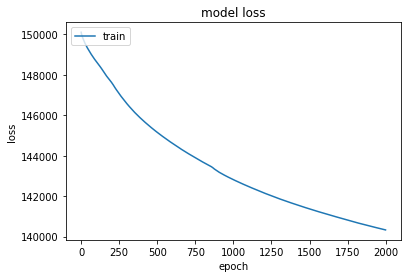

In [336]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [337]:
print('Score is : ', np.linalg.norm(lstm.predict(np.expand_dims(X_rec_train, axis=1)) - y_rec_val))

Score is :  8816.455103542268


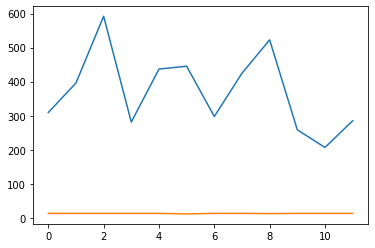

In [338]:
plt.plot(y_rec_val)
plt.plot(np.squeeze(lstm.predict(np.expand_dims(X_rec_val, axis=1))))

#### Time series

##### Decompose

Seasonal decompose requires a specific input format 

In [339]:
df_rec_test_decompose = df_multi_test[['year', 'woy', 'turnover']]
df_rec_test_decompose.loc[:, 'date'] = df_rec_test_decompose['year']*100 + df_rec_test_decompose['woy']
df_rec_test_decompose.loc[:, 'date'] = pd.to_datetime(df_rec_test_decompose['date'].apply(lambda x: str(x)+'-0'), format="%Y%W-%w")
df_rec_test_decompose = df_rec_test_decompose[['date', 'turnover']].set_index('date')

<Figure size 432x216 with 0 Axes>

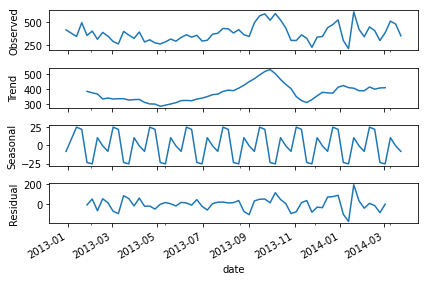

In [340]:
fig = plt.figure(figsize=(6,3))
stl = seasonal_decompose(df_rec_test_decompose, freq=7, model='additive')
_ = stl.plot()

###### Analysis

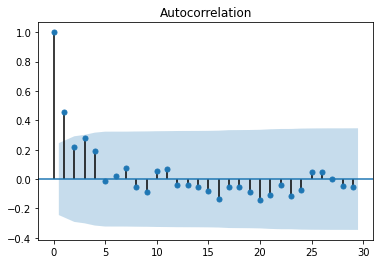

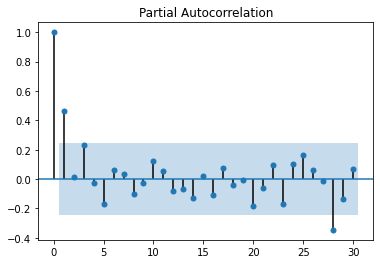

In [341]:
# Plots
y_plot = df_multi_test['turnover']
_ = plot_acf(y_plot, lags=min(30, len(y_plot))-1)
_ = plot_pacf(y_plot, lags=min(30, len(y_plot)-1))

No particular seasonality observed in the data given the ACF and PCF plots, except the trivial 7 days one


In [342]:
def LGBM_hyper_opt(learning_rate, n_estimators, max_depth):
    """
    Look for (sub-)optimal arg for the XGB regression model 
    """
    
    reg_model = LGBMRegressor(n_estimators=int(n_estimators), 
                              learning_rate=learning_rate,
                              max_depth=int(max_depth), 
                              min_data_in_leaf=0,
                              min_sum_hessian_in_leaf=0
                              )     
    score = get_scores({'Model': reg_model}, X, y, k=5)['Mse'].to_numpy()[0]
    return np.nanmin([score, 0])

# TODO : define the opt function after applying the model to the whole data
pbounds = {
  'learning_rate': (0.01, 1),
  'n_estimators': (50, 300),
  'max_depth': (3,15)
  }

optimizer = BayesianOptimization(f = LGBM_hyper_opt,
                                 pbounds = pbounds,
                                 random_state = 1)

optimizer.maximize(init_points=10, n_iter=100)
best_candidate = optimizer.max['params']

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------


100%|██████████| 1/1 [00:00<00:00,  7.64it/s]


|  1        |  0.0      |  0.4229   |  11.64    |  50.03    |


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


|  2        |  0.0      |  0.3093   |  4.761    |  73.08    |


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


|  3        |  0.0      |  0.1944   |  7.147    |  149.2    |


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


|  4        |  0.0      |  0.5434   |  8.03     |  221.3    |


100%|██████████| 1/1 [00:00<00:00,  6.18it/s]


|  5        |  0.0      |  0.2124   |  13.54    |  56.85    |


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


|  6        |  0.0      |  0.9192   |  14.23    |  300.0    |


100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


|  7        |  0.0      |  0.7885   |  3.658    |  299.7    |


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


|  8        |  0.0      |  0.8175   |  14.91    |  299.9    |


100%|██████████| 1/1 [00:00<00:00, 20.70it/s]


|  9        |  0.0      |  0.9992   |  3.365    |  50.02    |


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


|  10       |  0.0      |  0.0705   |  3.685    |  299.8    |


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


|  11       |  0.0      |  0.6554   |  14.7     |  50.66    |


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


|  12       |  0.0      |  0.1984   |  14.76    |  299.9    |


100%|██████████| 1/1 [00:00<00:00, 16.88it/s]


|  13       |  0.0      |  0.7875   |  3.531    |  50.09    |


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


|  14       |  0.0      |  0.07185  |  3.245    |  300.0    |


100%|██████████| 1/1 [00:00<00:00,  7.64it/s]


|  15       |  0.0      |  0.4893   |  14.41    |  50.28    |


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


|  16       |  0.0      |  0.05895  |  14.85    |  299.4    |


100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


|  17       |  0.0      |  0.8241   |  3.136    |  50.67    |


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


|  18       |  0.0      |  0.8136   |  3.075    |  299.7    |


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


|  19       |  0.0      |  0.407    |  14.96    |  51.11    |


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


|  20       |  0.0      |  0.7327   |  14.71    |  299.9    |


100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


|  21       |  0.0      |  0.05934  |  14.65    |  50.47    |


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


|  22       |  0.0      |  0.6631   |  3.27     |  299.5    |


100%|██████████| 1/1 [00:00<00:00, 19.84it/s]


|  23       |  0.0      |  0.4288   |  3.032    |  51.48    |


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


|  24       |  0.0      |  0.7532   |  3.349    |  299.5    |


100%|██████████| 1/1 [00:00<00:00, 28.56it/s]


|  25       |  0.0      |  0.9126   |  3.191    |  50.58    |


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


|  26       |  0.0      |  0.5708   |  14.44    |  299.8    |


100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


|  27       |  0.0      |  0.4471   |  14.92    |  51.17    |


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


|  28       |  0.0      |  0.7302   |  14.91    |  299.6    |


100%|██████████| 1/1 [00:00<00:00, 29.45it/s]


|  29       |  0.0      |  0.3338   |  3.157    |  50.24    |


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


|  30       |  0.0      |  0.1816   |  4.223    |  299.9    |


100%|██████████| 1/1 [00:00<00:00, 27.83it/s]


|  31       |  0.0      |  0.4983   |  3.222    |  50.67    |


100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


|  32       |  0.0      |  0.1079   |  3.052    |  298.9    |


100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


|  33       |  0.0      |  0.06656  |  14.29    |  50.28    |


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


|  34       |  0.0      |  0.509    |  14.93    |  299.8    |


100%|██████████| 1/1 [00:00<00:00, 13.30it/s]


|  35       |  0.0      |  0.6694   |  14.76    |  51.54    |


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


|  36       |  0.0      |  0.04421  |  14.95    |  299.7    |


100%|██████████| 1/1 [00:00<00:00, 24.70it/s]


|  37       |  0.0      |  0.8599   |  3.452    |  51.07    |


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


|  38       |  0.0      |  0.08326  |  3.519    |  299.7    |


100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


|  39       |  0.0      |  0.3542   |  14.81    |  50.27    |


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


|  40       |  0.0      |  0.08571  |  14.54    |  299.0    |


100%|██████████| 1/1 [00:00<00:00, 28.97it/s]


|  41       |  0.0      |  0.8827   |  3.318    |  50.45    |


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


|  42       |  0.0      |  0.3587   |  3.168    |  297.4    |


100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


|  43       |  0.0      |  0.07922  |  14.82    |  50.38    |


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


|  44       |  0.0      |  0.09126  |  14.73    |  299.0    |


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


|  45       |  0.0      |  0.7777   |  3.502    |  299.7    |


100%|██████████| 1/1 [00:00<00:00, 24.67it/s]


|  46       |  0.0      |  0.2214   |  3.284    |  51.03    |


100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


|  47       |  0.0      |  0.1612   |  15.0     |  53.13    |


100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


|  48       |  0.0      |  0.279    |  3.249    |  300.0    |


100%|██████████| 1/1 [00:00<00:00, 25.07it/s]


|  49       |  0.0      |  0.637    |  3.191    |  52.32    |


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


|  50       |  0.0      |  0.8712   |  14.63    |  299.7    |


100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


|  51       |  0.0      |  0.1196   |  14.24    |  51.59    |


100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


|  52       |  0.0      |  0.6123   |  3.148    |  298.9    |


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


|  53       |  0.0      |  0.9717   |  14.84    |  299.2    |


100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


|  54       |  0.0      |  0.3924   |  4.628    |  51.91    |


100%|██████████| 1/1 [00:00<00:00, 15.23it/s]


|  55       |  0.0      |  0.9427   |  14.92    |  50.32    |


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


|  56       |  0.0      |  0.6538   |  3.068    |  297.4    |


100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


|  57       |  0.0      |  0.3649   |  14.91    |  50.38    |


100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


|  58       |  0.0      |  0.2903   |  14.68    |  51.22    |


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


|  59       |  0.0      |  0.08149  |  3.312    |  299.6    |


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


|  60       |  0.0      |  0.4545   |  14.23    |  296.9    |


100%|██████████| 1/1 [00:00<00:00, 28.30it/s]


|  61       |  0.0      |  0.5454   |  3.548    |  53.13    |


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


|  62       |  0.0      |  0.9996   |  14.98    |  299.6    |


100%|██████████| 1/1 [00:00<00:00, 26.46it/s]


|  63       |  0.0      |  0.6947   |  3.022    |  50.16    |


100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


|  64       |  0.0      |  0.193    |  14.83    |  299.8    |


100%|██████████| 1/1 [00:00<00:00, 28.20it/s]


|  65       |  0.0      |  0.9628   |  3.98     |  50.69    |


100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


|  66       |  0.0      |  0.6143   |  3.917    |  297.5    |


100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


|  67       |  0.0      |  0.07048  |  14.7     |  51.21    |


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


|  68       |  0.0      |  0.5347   |  14.77    |  293.2    |


100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


|  69       |  0.0      |  0.969    |  3.493    |  298.8    |


100%|██████████| 1/1 [00:00<00:00, 26.31it/s]


|  70       |  0.0      |  0.4681   |  3.333    |  52.0     |


100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


|  71       |  0.0      |  0.3736   |  14.08    |  51.76    |


100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


|  72       |  0.0      |  0.7234   |  4.063    |  299.9    |


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


|  73       |  0.0      |  0.2632   |  13.93    |  294.9    |


100%|██████████| 1/1 [00:00<00:00, 26.61it/s]


|  74       |  0.0      |  0.01573  |  3.082    |  53.67    |


100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


|  75       |  0.0      |  0.6943   |  14.03    |  51.26    |


100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


|  76       |  0.0      |  0.2404   |  14.2     |  55.68    |


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


|  77       |  0.0      |  0.4483   |  14.84    |  298.3    |


100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


|  78       |  0.0      |  0.1264   |  14.93    |  58.04    |


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


|  79       |  0.0      |  0.9311   |  14.59    |  299.0    |


100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


|  80       |  0.0      |  0.2658   |  3.129    |  299.3    |


100%|██████████| 1/1 [00:00<00:00, 26.60it/s]


|  81       |  0.0      |  0.6509   |  3.236    |  50.95    |


100%|██████████| 1/1 [00:00<00:00, 28.23it/s]


|  82       |  0.0      |  0.2225   |  3.198    |  51.18    |


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


|  83       |  0.0      |  0.6012   |  3.105    |  297.3    |


100%|██████████| 1/1 [00:00<00:00, 28.10it/s]


|  84       |  0.0      |  0.8146   |  3.078    |  52.93    |


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


|  85       |  0.0      |  0.7012   |  14.93    |  298.8    |


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


|  86       |  0.0      |  0.4052   |  14.36    |  298.2    |


100%|██████████| 1/1 [00:00<00:00, 13.66it/s]


|  87       |  0.0      |  0.9461   |  15.0     |  60.23    |


100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


|  88       |  0.0      |  0.7647   |  3.138    |  298.7    |


100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


|  89       |  0.0      |  0.8432   |  3.606    |  296.6    |


100%|██████████| 1/1 [00:00<00:00, 26.53it/s]


|  90       |  0.0      |  0.247    |  3.438    |  50.77    |


100%|██████████| 1/1 [00:00<00:00, 25.14it/s]


|  91       |  0.0      |  0.06389  |  3.387    |  56.07    |


100%|██████████| 1/1 [00:00<00:00, 12.51it/s]


|  92       |  0.0      |  0.1373   |  14.16    |  50.82    |


100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


|  93       |  0.0      |  0.574    |  14.45    |  54.55    |


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


|  94       |  0.0      |  0.3929   |  3.745    |  298.9    |


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


|  95       |  0.0      |  0.06945  |  14.8     |  298.9    |


100%|██████████| 1/1 [00:00<00:00, 15.90it/s]


|  96       |  0.0      |  0.9855   |  14.74    |  54.2     |


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


|  97       |  0.0      |  0.3558   |  14.23    |  299.3    |


100%|██████████| 1/1 [00:00<00:00, 16.15it/s]


|  98       |  0.0      |  0.1083   |  3.051    |  56.06    |


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


|  99       |  0.0      |  0.9475   |  14.18    |  295.1    |


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


|  100      |  0.0      |  0.3959   |  14.99    |  289.3    |


100%|██████████| 1/1 [00:00<00:00,  6.62it/s]


|  101      |  0.0      |  0.9558   |  3.131    |  296.1    |


100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


|  102      |  0.0      |  0.7033   |  14.35    |  50.58    |


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


|  103      |  0.0      |  0.4397   |  4.018    |  297.9    |


100%|██████████| 1/1 [00:00<00:00, 16.68it/s]


|  104      |  0.0      |  0.1449   |  3.224    |  57.51    |


100%|██████████| 1/1 [00:00<00:00, 18.75it/s]

|  105      |  0.0      |  0.8989   |  3.579    |  51.78    |


In [343]:
int_types = {'n_estimators': int,
             'max_depth': int}

best_candidate = {key: int_types[key](value) if key in int_types else value for key, value in best_candidate.items()}

lgbm_reg_tuned = LGBMRegressor(**best_candidate, min_data_in_leaf=0, min_sum_hessian_in_leaf=0)
lgbm_reg_tuned.fit(X_train, y_train)
print('Score is : ', lgbm_reg_tuned.score(X_val, y_val))

Score is :  0.3534713581700769


### Prediction

In [344]:
def aggregated_model(dfs, model, buns, deps):
    """
    Broadcast the prediction to all vectors in 
    """
    y_preds = []
    
    for i in range(len(buns)):
        for j in range(len(deps)):
            
            sample = dfs[i][j]
            if len(sample)==0:
                continue
            
            X_sample = sample.copy().to_numpy()
            y_pred = model.predict(X_sample)
            sample.loc[:, 'turnover'] = y_pred
            sample.loc[:, 'bun'] = buns[i]
            sample.loc[:, 'dep'] = deps[j]
            y_preds.append(sample)

    return pd.concat(y_preds, ignore_index=True)

In [345]:
features = ['year', 'month', 'woy', 'bun', 'dep', 'win', 'spr', 'smm', 'aut', 'lat', 'lon', 'reg', 'zod']

df_test  = pd.read_csv(get_path('data/test', 'csv'))
df_test.loc[:, 'day_id'] = pd.to_datetime(df_test['day_id'])

# Process test data set in the same fashion as the training one
df_test = process_date_col(df_test).rename(columns = columns_mapping, inplace = False)
df_test  = df_test.merge(df_feat, on='bun', how='left').sort_values(by=['year', 'month', 'bun', 'dep']).reset_index()
df_test = season_col(df_test, 'woy')
df_test = df_test[features]

# Filter the testing department-businessunit combinations to the ones for which we have data
dep_buns = np.unique((df_train['bun']*1000).astype(str) + df_train['dep'].astype(str))
df_test_seen = df_test.loc[((df_test['bun']*1000).astype(str) + df_test['dep'].astype(str)).isin(dep_buns), :]
df_test_unseen = df_test.loc[~((df_test['bun']*1000).astype(str) + df_test['dep'].astype(str)).isin(dep_buns), :]

# Onehot encoding
df_test_seen = onehot_cols(df_test_seen, ['reg', 'zod'])

# Fill missing columns (assigning columns to dataframe that aren't in it has been deprecated)
cols = [_ for _ in df_train_multi.columns if not _ in  list(df_test_seen.columns) + ['turnover']]
for col in cols:
    df_test_seen.loc[:, col] = 0

In [346]:
buns = sorted(list(df_test_seen['bun'].unique()))
deps = sorted(list(df_test_seen['dep'].unique()))

columns = df_test_seen.columns
columns = [_ for _ in columns if _ not in ['buns', 'dep']]

dfs_seen = [[]]

for i, bun in enumerate(buns):
    for j, dep in enumerate(deps):
        sample = df_test_seen.loc[(df_test_seen['bun']==bun)&(df_test_seen['dep']==dep), columns].copy(True)
        sample = sample.sort_values(by=['year', 'month'])
        dfs_seen[-1].append(sample)
        
    dfs_seen.append([])

In [347]:
# Cast dataframe to numpy array
X_test_seen = df_test_seen.to_numpy()

# Make prediction
result_seen = aggregated_model(dfs_seen, lgbm_reg_tuned, buns, deps)

y_pred_unseen = list(np.ones_like(df_test_unseen.index)*np.mean(y_train))
result_unseen = df_test_unseen
result_unseen.loc[:, 'turnover'] = y_pred_unseen

result = pd.concat([result_seen, result_unseen], ignore_index=True)
result.loc[:, 'date'] = (result['year']*100).astype(int) + result['woy'].astype(int)
result.loc[:, 'date'] = pd.to_datetime(result['date'].apply(lambda x: str(x)+'-0'), format="%Y%W-%w")

# Get final result
result = result[['date',	'bun',	'dep', 'turnover']]

In [348]:
result

,date,bun,dep,turnover
0,2017-10-29,1,73,296.837128
1,2017-10-22,1,73,296.837128
2,2017-10-15,1,73,434.475067
3,2017-10-08,1,73,434.475067
4,2017-11-26,1,73,298.103084
...,...,...,...,...
10131,2017-11-05,1887,88,378.059869
10132,2017-11-26,1887,127,378.059869
10133,2017-11-19,1887,127,378.059869
10134,2017-11-12,1887,127,378.059869
